In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.cnn1_Res = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0) 
        self.batch1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.cnn2_Res = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0) 
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.cnn3_Res = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0) 
        self.batch3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  14  * 14  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.cnn4_Res = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0) 
        self.batch4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 128
        Out dimension Conv:        14  * 14  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.cnn5_Res = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0) 
        self.batch5 = nn.BatchNorm2d(128)
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        residual = x
        # Convolution
        x = self.cnn1_model(x)
        # Residual
        residual = self.cnn1_Res(residual)
        x += residual
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        residual = x
        # Convolution
        x = self.cnn2_model(x)
        # Residual
        residual = self.cnn2_Res(residual)
        x += residual
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        residual = x
        # Convolution
        x = self.cnn3_model(x)
        # Residual
        residual = self.cnn3_Res(residual)
        x += residual
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        residual = x
        # Convolution
        x = self.cnn4_model(x)
        # Residual
        residual = self.cnn4_Res(residual)
        x += residual
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        residual = x
        # Convolution
        x = self.cnn5_model(x)
        # Residual
        residual = self.cnn5_Res(residual)
        x += residual
        x = self.batch5(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn1_Res): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn2_Res): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 4297108


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-1.5699, -1.6213, -1.6213,  ...,  0.9132,  0.9132,  0.8789],
          [-1.6042, -1.6213, -1.6042,  ...,  0.9132,  0.9132,  0.8961],
          [-1.6213, -1.6213, -1.6042,  ...,  0.9303,  0.9132,  0.8961],
          ...,
          [-1.6213, -1.5870, -1.5699,  ..., -1.6213, -1.6213, -1.6384],
          [-1.6555, -1.6213, -1.6042,  ..., -1.6727, -1.6555, -1.6727],
          [-1.6384, -1.6042, -1.5870,  ..., -1.6727, -1.6727, -1.6727]],

         [[-1.3880, -1.4405, -1.4405,  ...,  0.9755,  0.9930,  1.0280],
          [-1.4230, -1.4405, -1.4230,  ...,  0.9755,  0.9930,  1.0105],
          [-1.4405, -1.4405, -1.4230,  ...,  0.9930,  1.0105,  0.9930],
          ...,
          [-1.3004, -1.2829, -1.3004,  ..., -1.3354, -1.3354, -1.3529],
          [-1.3354, -1.3179, -1.3354,  ..., -1.3704, -1.3529, -1.3880],
          [-1.3179, -1.3179, -1.3179,  ..., -1.38

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


train loss:  0.07401367543513816
Val loss:  0.14634967575902524
train accuracy:  0.539651837524178
Val accuracy:  0.6260869565217392
Current time: 3.515 minutes. Time expected till completion: 1753.789 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.07005459444896396
Val loss:  0.14425497521524844
train accuracy:  0.5996131528046421
Val accuracy:  0.6173913043478261
Current time: 3.884 minutes. Time expected till completion: 967.001 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06851900655711413
Val loss:  0.151561933496724
train accuracy:  0.6073500967117988
Val accuracy:  0.5304347826086957
Current time: 4.196 minutes. Time expected till completion: 695.206 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


train loss:  0.06828338714817275
Val loss:  0.14220727578453396
train accuracy:  0.6141199226305609
Val accuracy:  0.6521739130434783
Current time: 4.555 minutes. Time expected till completion: 564.761 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 15.13it/s]


train loss:  0.06868004037978802
Val loss:  0.14251338606295377
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 4.935 minutes. Time expected till completion: 488.610 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06800769116707882
Val loss:  0.1510972059291342
train accuracy:  0.6141199226305609
Val accuracy:  0.5478260869565217
Current time: 5.261 minutes. Time expected till completion: 433.152 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.0680176437016382
Val loss:  0.14045923689137335
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 5.598 minutes. Time expected till completion: 394.253 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06785875432034756
Val loss:  0.13997605106104974
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 5.918 minutes. Time expected till completion: 363.945 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06810672099862385
Val loss:  0.14000470016313635
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 6.240 minutes. Time expected till completion: 340.427 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.0674644789912484
Val loss:  0.14036546219950136
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 6.567 minutes. Time expected till completion: 321.792 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06761756049364633
Val loss:  0.14010089324868244
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 6.890 minutes. Time expected till completion: 306.312 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06738862954440385
Val loss:  0.14002156620440276
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 7.214 minutes. Time expected till completion: 293.387 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06730270795019729
Val loss:  0.14284832011098447
train accuracy:  0.6199226305609284
Val accuracy:  0.6086956521739131
Current time: 7.539 minutes. Time expected till completion: 282.435 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.0673988671897689
Val loss:  0.14041074307068535
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 7.866 minutes. Time expected till completion: 273.060 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06692276765345605
Val loss:  0.1393818103748819
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 8.190 minutes. Time expected till completion: 264.811 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06749785113611351
Val loss:  0.14112176376840344
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 8.516 minutes. Time expected till completion: 257.602 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06710118758609263
Val loss:  0.14079756270284238
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 8.842 minutes. Time expected till completion: 251.215 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06706288330098416
Val loss:  0.13997377105381179
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 9.167 minutes. Time expected till completion: 245.471 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.0670217688932179
Val loss:  0.1390295852785525
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 9.494 minutes. Time expected till completion: 240.357 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06672435238006268
Val loss:  0.1396342609239661
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 9.819 minutes. Time expected till completion: 235.644 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 15.73it/s]


train loss:  0.06673234418697468
Val loss:  0.1393033063930014
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 10.147 minutes. Time expected till completion: 231.442 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06659267505547986
Val loss:  0.14061561408250228
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 10.472 minutes. Time expected till completion: 227.537 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06677177110308605
Val loss:  0.13936915864115176
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 10.797 minutes. Time expected till completion: 223.911 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.0667445212890839
Val loss:  0.13860687743062558
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 11.121 minutes. Time expected till completion: 220.566 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06679361170910775
Val loss:  0.13881785558617632
train accuracy:  0.6179883945841392
Val accuracy:  0.6347826086956522
Current time: 11.446 minutes. Time expected till completion: 217.472 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.06689617666100625
Val loss:  0.1391183941260628
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 11.774 minutes. Time expected till completion: 214.649 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06629485001416455
Val loss:  0.13949146633562834
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 12.098 minutes. Time expected till completion: 211.941 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06661192752867649
Val loss:  0.13773542798083763
train accuracy:  0.620889748549323
Val accuracy:  0.6782608695652174
Current time: 12.423 minutes. Time expected till completion: 209.411 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06617160530569936
Val loss:  0.13879551110060317
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 12.748 minutes. Time expected till completion: 207.041 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.06608281686642645
Val loss:  0.13993054369221564
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 13.075 minutes. Time expected till completion: 204.838 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06567899165116611
Val loss:  0.1387979973917422
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 13.402 minutes. Time expected till completion: 202.757 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06619160779440196
Val loss:  0.1382982497629912
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 13.728 minutes. Time expected till completion: 200.770 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06590218971730201
Val loss:  0.13787321318750795
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 14.053 minutes. Time expected till completion: 198.867 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06640420609101566
Val loss:  0.13829833839250646
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 14.379 minutes. Time expected till completion: 197.081 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06568282185486253
Val loss:  0.13745790305344954
train accuracy:  0.6218568665377177
Val accuracy:  0.6347826086956522
Current time: 14.705 minutes. Time expected till completion: 195.362 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06601459370129804
Val loss:  0.13778338380481886
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 15.030 minutes. Time expected till completion: 193.721 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06577955535117616
Val loss:  0.1385973723038383
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 15.355 minutes. Time expected till completion: 192.149 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06625560744588103
Val loss:  0.13742140324219412
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 15.680 minutes. Time expected till completion: 190.638 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.06586770410694513
Val loss:  0.1358510717101719
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 16.005 minutes. Time expected till completion: 189.191 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.06595664668821044
Val loss:  0.13741499392882636
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 16.339 minutes. Time expected till completion: 187.902 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06585275077727593
Val loss:  0.13740608018377554
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 16.669 minutes. Time expected till completion: 186.613 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06622523674651318
Val loss:  0.13674729803334112
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 16.997 minutes. Time expected till completion: 185.348 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.06591013056627787
Val loss:  0.13614984439766925
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 17.323 minutes. Time expected till completion: 184.110 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06584462027715761
Val loss:  0.13579759908759076
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 17.650 minutes. Time expected till completion: 182.922 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06586932104145765
Val loss:  0.1382548591364985
train accuracy:  0.6247582205029013
Val accuracy:  0.6782608695652174
Current time: 17.977 minutes. Time expected till completion: 181.770 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.0655717020800312
Val loss:  0.13781909942626952
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 18.302 minutes. Time expected till completion: 180.634 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06549473663132703
Val loss:  0.13621751018192457
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 18.627 minutes. Time expected till completion: 179.536 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.0656425046159866
Val loss:  0.13755961397419805
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 18.954 minutes. Time expected till completion: 178.480 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06569796523918728
Val loss:  0.13768697821575662
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 19.282 minutes. Time expected till completion: 177.476 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06538942156492857
Val loss:  0.14029203860656075
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 19.608 minutes. Time expected till completion: 176.473 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06516869559278801
Val loss:  0.13738113227097884
train accuracy:  0.6295938104448743
Val accuracy:  0.6782608695652174
Current time: 19.933 minutes. Time expected till completion: 175.486 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.06532666075621629
Val loss:  0.13575158948483673
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 20.259 minutes. Time expected till completion: 174.543 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06516706712933067
Val loss:  0.1363494769386623
train accuracy:  0.632495164410058
Val accuracy:  0.6695652173913044
Current time: 20.586 minutes. Time expected till completion: 173.620 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06521357402810737
Val loss:  0.13735648341800855
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 20.911 minutes. Time expected till completion: 172.712 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06551261254851085
Val loss:  0.13618220298186592
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 21.237 minutes. Time expected till completion: 171.827 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06514173037078902
Val loss:  0.13525144431902014
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 21.563 minutes. Time expected till completion: 170.965 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.06498843466059613
Val loss:  0.13581100443135138
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 21.889 minutes. Time expected till completion: 170.123 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06482050716300536
Val loss:  0.13762095648309458
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 22.218 minutes. Time expected till completion: 169.315 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06507944386286708
Val loss:  0.13590758727944416
train accuracy:  0.6363636363636364
Val accuracy:  0.6869565217391305
Current time: 22.545 minutes. Time expected till completion: 168.513 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06454831015902285
Val loss:  0.13609468936920166
train accuracy:  0.6392649903288201
Val accuracy:  0.6695652173913044
Current time: 22.871 minutes. Time expected till completion: 167.722 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.06481253507058901
Val loss:  0.13615023675172225
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 23.199 minutes. Time expected till completion: 166.955 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06466173364761028
Val loss:  0.1360202053318853
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 23.527 minutes. Time expected till completion: 166.208 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06478951983802324
Val loss:  0.1348956330962803
train accuracy:  0.655705996131528
Val accuracy:  0.6869565217391305
Current time: 23.854 minutes. Time expected till completion: 165.465 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06488529124389072
Val loss:  0.13616557224937106
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 24.181 minutes. Time expected till completion: 164.732 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06477519247241362
Val loss:  0.13586169740428095
train accuracy:  0.6411992263056093
Val accuracy:  0.6695652173913044
Current time: 24.508 minutes. Time expected till completion: 164.014 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06476903618880812
Val loss:  0.13523529249688854
train accuracy:  0.6421663442940039
Val accuracy:  0.6608695652173913
Current time: 24.835 minutes. Time expected till completion: 163.307 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06431507614641171
Val loss:  0.13577958034432452
train accuracy:  0.6460348162475822
Val accuracy:  0.6956521739130435
Current time: 25.166 minutes. Time expected till completion: 162.643 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.0648162348819194
Val loss:  0.13506319056386534
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 25.492 minutes. Time expected till completion: 161.950 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06434039780203563
Val loss:  0.1352636114410732
train accuracy:  0.6460348162475822
Val accuracy:  0.6608695652173913
Current time: 25.819 minutes. Time expected till completion: 161.276 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.0644714893985763
Val loss:  0.13579861651296202
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 26.146 minutes. Time expected till completion: 160.610 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06432661172038581
Val loss:  0.1362744372823964
train accuracy:  0.6431334622823984
Val accuracy:  0.6434782608695652
Current time: 26.473 minutes. Time expected till completion: 159.958 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:01<00:00, 12.43it/s]


train loss:  0.06396052950355485
Val loss:  0.13683871134467748
train accuracy:  0.6382978723404256
Val accuracy:  0.6782608695652174
Current time: 26.803 minutes. Time expected till completion: 159.328 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06462335286795286
Val loss:  0.13668213564416637
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 27.129 minutes. Time expected till completion: 158.688 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.06415284435108044
Val loss:  0.13610008177549943
train accuracy:  0.6470019342359767
Val accuracy:  0.6608695652173913
Current time: 27.460 minutes. Time expected till completion: 158.080 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.0639467960515382
Val loss:  0.1346034780792568
train accuracy:  0.6518375241779497
Val accuracy:  0.6695652173913044
Current time: 27.787 minutes. Time expected till completion: 157.457 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06460957272370964
Val loss:  0.13534502723942632
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 28.117 minutes. Time expected till completion: 156.865 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06369649182205274
Val loss:  0.14070577621459962
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 28.444 minutes. Time expected till completion: 156.255 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.0645269944658593
Val loss:  0.1345532774925232
train accuracy:  0.6508704061895552
Val accuracy:  0.6782608695652174
Current time: 28.769 minutes. Time expected till completion: 155.648 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06391651072400681
Val loss:  0.13495844395264336
train accuracy:  0.6421663442940039
Val accuracy:  0.6608695652173913
Current time: 29.095 minutes. Time expected till completion: 155.049 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


train loss:  0.06408491742218947
Val loss:  0.1347020947414896
train accuracy:  0.6624758220502901
Val accuracy:  0.6608695652173913
Current time: 29.424 minutes. Time expected till completion: 154.476 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06413711022362258
Val loss:  0.13676875415055648
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 29.749 minutes. Time expected till completion: 153.885 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06389041922309181
Val loss:  0.13808621945588484
train accuracy:  0.6586073500967118
Val accuracy:  0.6869565217391305
Current time: 30.075 minutes. Time expected till completion: 153.308 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06433696736450122
Val loss:  0.1370792673981708
train accuracy:  0.6508704061895552
Val accuracy:  0.6521739130434783
Current time: 30.403 minutes. Time expected till completion: 152.746 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06345134103090666
Val loss:  0.13340801259745722
train accuracy:  0.6576402321083172
Val accuracy:  0.6869565217391305
Current time: 30.730 minutes. Time expected till completion: 152.187 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


train loss:  0.06384789736174061
Val loss:  0.13517783206442127
train accuracy:  0.6537717601547389
Val accuracy:  0.6608695652173913
Current time: 31.057 minutes. Time expected till completion: 151.633 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06376867512208581
Val loss:  0.13761840333109315
train accuracy:  0.6528046421663443
Val accuracy:  0.6695652173913044
Current time: 31.387 minutes. Time expected till completion: 151.095 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.06391287714646449
Val loss:  0.1356431613797727
train accuracy:  0.6547388781431335
Val accuracy:  0.6695652173913044
Current time: 31.713 minutes. Time expected till completion: 150.548 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06376962343544287
Val loss:  0.13471349322277568
train accuracy:  0.6528046421663443
Val accuracy:  0.6608695652173913
Current time: 32.044 minutes. Time expected till completion: 150.024 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.0638438910534119
Val loss:  0.13643157482147217
train accuracy:  0.6547388781431335
Val accuracy:  0.6608695652173913
Current time: 32.371 minutes. Time expected till completion: 149.488 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06395197963806831
Val loss:  0.1341537999070209
train accuracy:  0.6499032882011605
Val accuracy:  0.6782608695652174
Current time: 32.696 minutes. Time expected till completion: 148.951 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06379009630509457
Val loss:  0.1359734022099039
train accuracy:  0.6518375241779497
Val accuracy:  0.6782608695652174
Current time: 33.022 minutes. Time expected till completion: 148.416 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.06392241475429941
Val loss:  0.13437656526980193
train accuracy:  0.655705996131528
Val accuracy:  0.6782608695652174
Current time: 33.349 minutes. Time expected till completion: 147.895 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06338528213694662
Val loss:  0.1368610081465348
train accuracy:  0.6702127659574468
Val accuracy:  0.6608695652173913
Current time: 33.678 minutes. Time expected till completion: 147.388 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06370652419455508
Val loss:  0.13520886379739513
train accuracy:  0.6624758220502901
Val accuracy:  0.6782608695652174
Current time: 34.004 minutes. Time expected till completion: 146.867 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06349549786956905
Val loss:  0.13644278619600378
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 34.330 minutes. Time expected till completion: 146.353 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.06352034147749556
Val loss:  0.13571656164915666
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 34.656 minutes. Time expected till completion: 145.846 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06297473739148109
Val loss:  0.13633367756138678
train accuracy:  0.6760154738878144
Val accuracy:  0.6695652173913044
Current time: 34.984 minutes. Time expected till completion: 145.345 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06326367436571324
Val loss:  0.13376391555951989
train accuracy:  0.655705996131528
Val accuracy:  0.6956521739130435
Current time: 35.310 minutes. Time expected till completion: 144.841 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06383419820833483
Val loss:  0.1358612765436587
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 35.636 minutes. Time expected till completion: 144.343 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06345854788960986
Val loss:  0.1348273780034936
train accuracy:  0.6731141199226306
Val accuracy:  0.7043478260869566
Saving model checkpoint


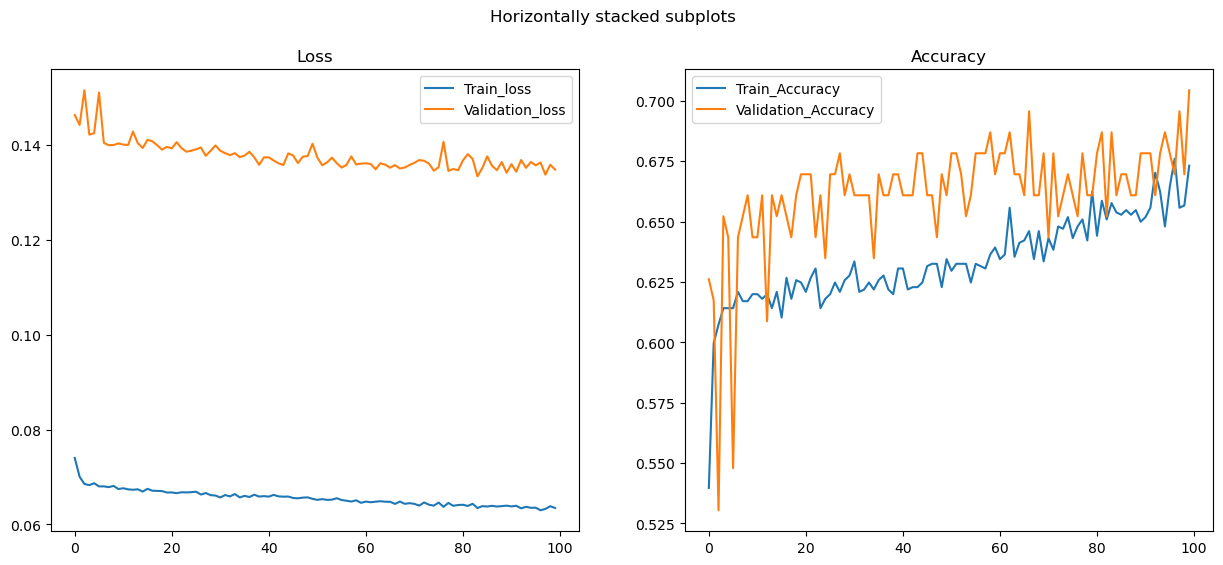

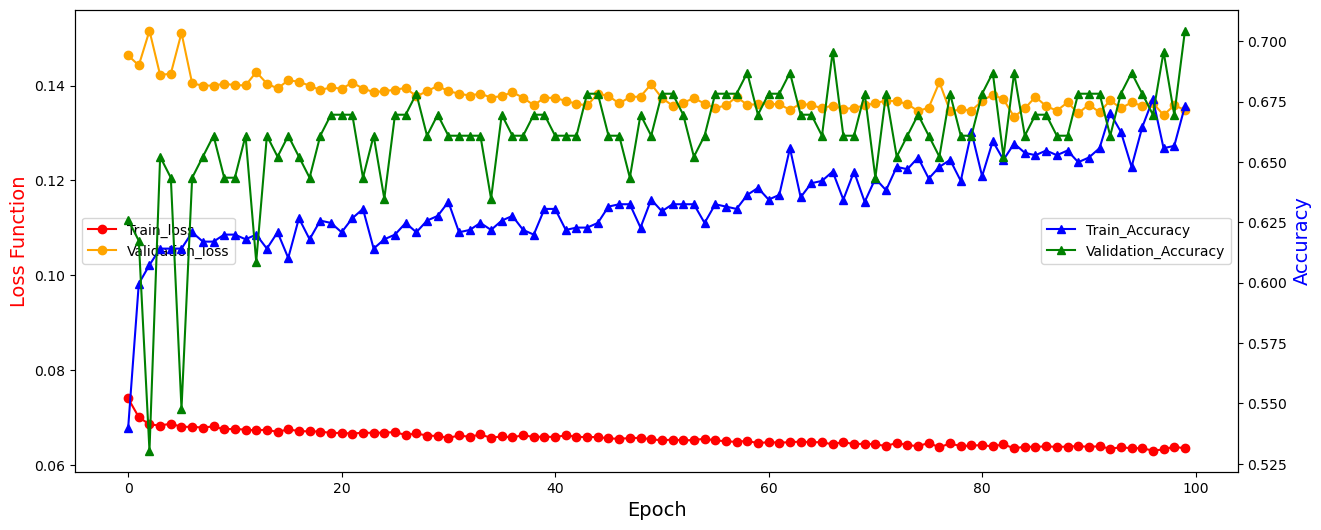

Current time: 36.285 minutes. Time expected till completion: 145.141 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06314934527850935
Val loss:  0.13713328112726625
train accuracy:  0.6586073500967118
Val accuracy:  0.6695652173913044
Current time: 36.599 minutes. Time expected till completion: 144.585 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06349516145495888
Val loss:  0.1341711541880732
train accuracy:  0.6653771760154739
Val accuracy:  0.6869565217391305
Current time: 36.925 minutes. Time expected till completion: 144.079 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06336030969306164
Val loss:  0.13566259249396947
train accuracy:  0.6682785299806576
Val accuracy:  0.6260869565217392
Current time: 37.252 minutes. Time expected till completion: 143.583 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06365500652813127
Val loss:  0.13586810516274495
train accuracy:  0.6595744680851063
Val accuracy:  0.6347826086956522
Current time: 37.579 minutes. Time expected till completion: 143.090 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.06315158068326733
Val loss:  0.13483085010362708
train accuracy:  0.6721470019342359
Val accuracy:  0.6695652173913044
Current time: 37.908 minutes. Time expected till completion: 142.605 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 15.78it/s]


train loss:  0.06265267948809168
Val loss:  0.13634798578594043
train accuracy:  0.6644100580270793
Val accuracy:  0.6608695652173913
Current time: 38.234 minutes. Time expected till completion: 142.115 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06287659344405686
Val loss:  0.13594491637271383
train accuracy:  0.6827852998065764
Val accuracy:  0.7043478260869566
Current time: 38.561 minutes. Time expected till completion: 141.630 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06323481839676198
Val loss:  0.13856523710748422
train accuracy:  0.6731141199226306
Val accuracy:  0.6956521739130435
Current time: 38.887 minutes. Time expected till completion: 141.145 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.0633090754657465
Val loss:  0.13375241704609084
train accuracy:  0.6711798839458414
Val accuracy:  0.6695652173913044
Current time: 39.214 minutes. Time expected till completion: 140.665 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06290555259706435
Val loss:  0.13905963016592937
train accuracy:  0.6537717601547389
Val accuracy:  0.6695652173913044
Current time: 39.542 minutes. Time expected till completion: 140.196 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06329636457349161
Val loss:  0.13271646706954293
train accuracy:  0.6644100580270793
Val accuracy:  0.6695652173913044
Current time: 39.869 minutes. Time expected till completion: 139.721 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06257486527846906
Val loss:  0.1355664191038712
train accuracy:  0.6740812379110251
Val accuracy:  0.6695652173913044
Current time: 40.196 minutes. Time expected till completion: 139.249 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


train loss:  0.0625535326377566
Val loss:  0.13538792547972306
train accuracy:  0.6634429400386848
Val accuracy:  0.6608695652173913
Current time: 40.522 minutes. Time expected till completion: 138.777 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.0628171368309331
Val loss:  0.1387162332949431
train accuracy:  0.6624758220502901
Val accuracy:  0.6869565217391305
Current time: 40.849 minutes. Time expected till completion: 138.312 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06303283606783795
Val loss:  0.1357469626094984
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 41.176 minutes. Time expected till completion: 137.849 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06316488399035235
Val loss:  0.13704829889795053
train accuracy:  0.6711798839458414
Val accuracy:  0.6695652173913044
Current time: 41.503 minutes. Time expected till completion: 137.388 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06268001179169409
Val loss:  0.13658654689788818
train accuracy:  0.6682785299806576
Val accuracy:  0.6782608695652174
Current time: 41.830 minutes. Time expected till completion: 136.929 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.06240604192422022
Val loss:  0.1375783795895784
train accuracy:  0.6847195357833655
Val accuracy:  0.6956521739130435
Current time: 42.157 minutes. Time expected till completion: 136.473 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06234633121315238
Val loss:  0.13495623650758162
train accuracy:  0.6808510638297872
Val accuracy:  0.6869565217391305
Current time: 42.484 minutes. Time expected till completion: 136.020 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06254620299579096
Val loss:  0.1357049180113751
train accuracy:  0.6856866537717602
Val accuracy:  0.6608695652173913
Current time: 42.809 minutes. Time expected till completion: 135.562 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06266150414597826
Val loss:  0.13813063217246013
train accuracy:  0.6702127659574468
Val accuracy:  0.6608695652173913
Current time: 43.135 minutes. Time expected till completion: 135.110 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06272112815938097
Val loss:  0.13346032526182092
train accuracy:  0.6615087040618955
Val accuracy:  0.6956521739130435
Current time: 43.462 minutes. Time expected till completion: 134.662 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06259393380735091
Val loss:  0.1345497488975525
train accuracy:  0.6876208897485493
Val accuracy:  0.6695652173913044
Current time: 43.790 minutes. Time expected till completion: 134.218 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06272689712808487
Val loss:  0.13489864028018453
train accuracy:  0.6934235976789168
Val accuracy:  0.7043478260869566
Current time: 44.116 minutes. Time expected till completion: 133.772 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06286675867766892
Val loss:  0.1346222602802774
train accuracy:  0.6760154738878144
Val accuracy:  0.6782608695652174
Current time: 44.444 minutes. Time expected till completion: 133.331 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.062164242193823396
Val loss:  0.13561843633651732
train accuracy:  0.6914893617021277
Val accuracy:  0.6521739130434783
Current time: 44.772 minutes. Time expected till completion: 132.894 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06218852099874264
Val loss:  0.13608773117480072
train accuracy:  0.6914893617021277
Val accuracy:  0.6434782608695652
Current time: 45.106 minutes. Time expected till completion: 132.476 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06235642082686581
Val loss:  0.13947311276974886
train accuracy:  0.6934235976789168
Val accuracy:  0.6173913043478261
Current time: 45.432 minutes. Time expected till completion: 132.038 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.062199391813757804
Val loss:  0.1353589223778766
train accuracy:  0.6731141199226306
Val accuracy:  0.6782608695652174
Current time: 45.759 minutes. Time expected till completion: 131.601 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06231138006400324
Val loss:  0.13655122674029807
train accuracy:  0.683752417794971
Val accuracy:  0.6956521739130435
Current time: 46.085 minutes. Time expected till completion: 131.165 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.06255604364194077
Val loss:  0.13345758966777635
train accuracy:  0.6856866537717602
Val accuracy:  0.6782608695652174
Current time: 46.412 minutes. Time expected till completion: 130.734 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06213781081961479
Val loss:  0.13357662999111672
train accuracy:  0.6934235976789168
Val accuracy:  0.6521739130434783
Current time: 46.740 minutes. Time expected till completion: 130.307 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06226432519447873
Val loss:  0.13492221002993376
train accuracy:  0.6827852998065764
Val accuracy:  0.6695652173913044
Current time: 47.068 minutes. Time expected till completion: 129.880 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.062130349690033344
Val loss:  0.13534659354583076
train accuracy:  0.7021276595744681
Val accuracy:  0.6782608695652174
Current time: 47.398 minutes. Time expected till completion: 129.460 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.062009652474862696
Val loss:  0.13797267934550408
train accuracy:  0.7040618955512572
Val accuracy:  0.6782608695652174
Current time: 47.727 minutes. Time expected till completion: 129.038 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.062146073844953936
Val loss:  0.13684734779855479
train accuracy:  0.688588007736944
Val accuracy:  0.6695652173913044
Current time: 48.058 minutes. Time expected till completion: 128.626 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06228170974803386
Val loss:  0.13402535448903624
train accuracy:  0.6808510638297872
Val accuracy:  0.6608695652173913
Current time: 48.384 minutes. Time expected till completion: 128.199 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


train loss:  0.06210306534684142
Val loss:  0.13339571071707684
train accuracy:  0.6943907156673114
Val accuracy:  0.6869565217391305
Current time: 48.709 minutes. Time expected till completion: 127.774 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.06174573469438682
Val loss:  0.13426620597424715
train accuracy:  0.695357833655706
Val accuracy:  0.6869565217391305
Current time: 49.037 minutes. Time expected till completion: 127.355 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


train loss:  0.06243911817871625
Val loss:  0.1345415006513181
train accuracy:  0.6943907156673114
Val accuracy:  0.7130434782608696
Current time: 49.366 minutes. Time expected till completion: 126.940 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06158623047446836
Val loss:  0.13718740525452988
train accuracy:  0.6963249516441006
Val accuracy:  0.6434782608695652
Current time: 49.694 minutes. Time expected till completion: 126.525 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06191248445261839
Val loss:  0.1385519089906112
train accuracy:  0.6943907156673114
Val accuracy:  0.6695652173913044
Current time: 50.020 minutes. Time expected till completion: 126.107 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.06200590816180526
Val loss:  0.13743040561676026
train accuracy:  0.6789168278529981
Val accuracy:  0.6608695652173913
Current time: 50.347 minutes. Time expected till completion: 125.690 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.06226681740648281
Val loss:  0.14622822844463845
train accuracy:  0.6876208897485493
Val accuracy:  0.6086956521739131
Current time: 50.673 minutes. Time expected till completion: 125.276 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.062081619491890734
Val loss:  0.1342422832613406
train accuracy:  0.6972920696324951
Val accuracy:  0.6434782608695652
Current time: 51.000 minutes. Time expected till completion: 124.863 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06156635025022569
Val loss:  0.13574690300485362
train accuracy:  0.6982591876208898
Val accuracy:  0.6869565217391305
Current time: 51.326 minutes. Time expected till completion: 124.447 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06160052705779528
Val loss:  0.1374110828275266
train accuracy:  0.7088974854932302
Val accuracy:  0.6434782608695652
Current time: 51.653 minutes. Time expected till completion: 124.037 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.06178285322751943
Val loss:  0.1361850546753925
train accuracy:  0.706963249516441
Val accuracy:  0.7130434782608696
Current time: 51.980 minutes. Time expected till completion: 123.628 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.06173018249367838
Val loss:  0.13860916884049126
train accuracy:  0.690522243713733
Val accuracy:  0.6434782608695652
Current time: 52.307 minutes. Time expected till completion: 123.219 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.062123643014601625
Val loss:  0.13712411289629728
train accuracy:  0.7214700193423598
Val accuracy:  0.6956521739130435
Current time: 52.634 minutes. Time expected till completion: 122.812 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.061758888413412656
Val loss:  0.13611903397933298
train accuracy:  0.7127659574468085
Val accuracy:  0.6695652173913044
Current time: 52.960 minutes. Time expected till completion: 122.404 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.061954548211346744
Val loss:  0.13615209123362665
train accuracy:  0.6934235976789168
Val accuracy:  0.6956521739130435
Current time: 53.286 minutes. Time expected till completion: 121.997 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


train loss:  0.061382480239499236
Val loss:  0.1360936496568763
train accuracy:  0.7050290135396519
Val accuracy:  0.7130434782608696
Current time: 53.614 minutes. Time expected till completion: 121.596 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06164101457918636
Val loss:  0.13378887798475184
train accuracy:  0.6992263056092843
Val accuracy:  0.6869565217391305
Current time: 53.941 minutes. Time expected till completion: 121.193 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06071890893480533
Val loss:  0.14006053779436195
train accuracy:  0.7117988394584139
Val accuracy:  0.6608695652173913
Current time: 54.268 minutes. Time expected till completion: 120.790 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.061901377813036715
Val loss:  0.13465328838514246
train accuracy:  0.695357833655706
Val accuracy:  0.7130434782608696
Current time: 54.597 minutes. Time expected till completion: 120.392 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.06170506709087748
Val loss:  0.13739931272423786
train accuracy:  0.7050290135396519
Val accuracy:  0.6956521739130435
Current time: 54.923 minutes. Time expected till completion: 119.992 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.061392237070220124
Val loss:  0.13688205065934556
train accuracy:  0.7147001934235977
Val accuracy:  0.7130434782608696
Current time: 55.250 minutes. Time expected till completion: 119.592 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.06143674289004254
Val loss:  0.13731470263522605
train accuracy:  0.718568665377176
Val accuracy:  0.6434782608695652
Current time: 55.577 minutes. Time expected till completion: 119.193 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.061399854301714574
Val loss:  0.1385357317717179
train accuracy:  0.7176015473887815
Val accuracy:  0.6521739130434783
Current time: 55.905 minutes. Time expected till completion: 118.798 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.0617064167268041
Val loss:  0.134736516682998
train accuracy:  0.7224371373307543
Val accuracy:  0.6782608695652174
Current time: 56.231 minutes. Time expected till completion: 118.400 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.06044390117407306
Val loss:  0.1370427411535512
train accuracy:  0.7263056092843327
Val accuracy:  0.6956521739130435
Current time: 56.558 minutes. Time expected till completion: 118.004 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06113781441341747
Val loss:  0.13715957092202227
train accuracy:  0.723404255319149
Val accuracy:  0.6347826086956522
Current time: 56.883 minutes. Time expected till completion: 117.606 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06077093410538059
Val loss:  0.1354848923890487
train accuracy:  0.7321083172147002
Val accuracy:  0.7217391304347827
Current time: 57.211 minutes. Time expected till completion: 117.213 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06060120227027908
Val loss:  0.1360530506009641
train accuracy:  0.7166344294003868
Val accuracy:  0.6869565217391305
Current time: 57.538 minutes. Time expected till completion: 116.819 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.060940705888275944
Val loss:  0.13868941431460174
train accuracy:  0.730174081237911
Val accuracy:  0.6608695652173913
Current time: 57.864 minutes. Time expected till completion: 116.425 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.061232911837170154
Val loss:  0.13599361284919406
train accuracy:  0.7263056092843327
Val accuracy:  0.7217391304347827
Current time: 58.191 minutes. Time expected till completion: 116.033 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06099513207690167
Val loss:  0.1338770363641822
train accuracy:  0.7272727272727273
Val accuracy:  0.6782608695652174
Current time: 58.519 minutes. Time expected till completion: 115.645 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06040101136644758
Val loss:  0.1357059940047886
train accuracy:  0.7408123791102514
Val accuracy:  0.6956521739130435
Current time: 58.847 minutes. Time expected till completion: 115.256 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.060577087406955325
Val loss:  0.13713509932808254
train accuracy:  0.7253384912959381
Val accuracy:  0.6608695652173913
Current time: 59.173 minutes. Time expected till completion: 114.866 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.06102373573489531
Val loss:  0.13445793442104173
train accuracy:  0.7214700193423598
Val accuracy:  0.6869565217391305
Current time: 59.500 minutes. Time expected till completion: 114.476 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.061169479525066205
Val loss:  0.13762210400208183
train accuracy:  0.7340425531914894
Val accuracy:  0.7043478260869566
Current time: 59.826 minutes. Time expected till completion: 114.087 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06109579942212575
Val loss:  0.1382364511489868
train accuracy:  0.7311411992263056
Val accuracy:  0.6086956521739131
Current time: 60.152 minutes. Time expected till completion: 113.697 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 15.78it/s]


train loss:  0.06068051852847898
Val loss:  0.13680396235507467
train accuracy:  0.7388781431334622
Val accuracy:  0.6521739130434783
Current time: 60.478 minutes. Time expected till completion: 113.310 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.060915448910032526
Val loss:  0.1392980098724365
train accuracy:  0.7350096711798839
Val accuracy:  0.6434782608695652
Current time: 60.804 minutes. Time expected till completion: 112.922 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


train loss:  0.060895250371623084
Val loss:  0.1390097421148549
train accuracy:  0.7195357833655706
Val accuracy:  0.6434782608695652
Current time: 61.131 minutes. Time expected till completion: 112.536 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06080836945391716
Val loss:  0.14355985807335894
train accuracy:  0.7330754352030948
Val accuracy:  0.5652173913043478
Current time: 61.457 minutes. Time expected till completion: 112.151 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.061092195185748016
Val loss:  0.13632695156594982
train accuracy:  0.7156673114119922
Val accuracy:  0.6869565217391305
Current time: 61.783 minutes. Time expected till completion: 111.765 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.060814820417352526
Val loss:  0.13652636279230532
train accuracy:  0.7446808510638298
Val accuracy:  0.6782608695652174
Current time: 62.109 minutes. Time expected till completion: 111.380 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.06041353514392787
Val loss:  0.1344794677651447
train accuracy:  0.7369439071566731
Val accuracy:  0.6956521739130435
Current time: 62.436 minutes. Time expected till completion: 110.998 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06027451566847427
Val loss:  0.1354917505513067
train accuracy:  0.7282398452611218
Val accuracy:  0.6956521739130435
Current time: 62.761 minutes. Time expected till completion: 110.612 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.060346514735968936
Val loss:  0.13638337695080302
train accuracy:  0.7437137330754352
Val accuracy:  0.6869565217391305
Current time: 63.087 minutes. Time expected till completion: 110.230 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.0600398575429529
Val loss:  0.13667097247165183
train accuracy:  0.746615087040619
Val accuracy:  0.6347826086956522
Current time: 63.416 minutes. Time expected till completion: 109.851 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 15.78it/s]


train loss:  0.060619239938558875
Val loss:  0.1398915902428005
train accuracy:  0.7446808510638298
Val accuracy:  0.6521739130434783
Current time: 63.741 minutes. Time expected till completion: 109.468 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06052948935119511
Val loss:  0.14121757279271666
train accuracy:  0.7495164410058027
Val accuracy:  0.6521739130434783
Current time: 64.067 minutes. Time expected till completion: 109.087 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06004405603879195
Val loss:  0.14226621959520422
train accuracy:  0.7456479690522244
Val accuracy:  0.6
Current time: 64.394 minutes. Time expected till completion: 108.708 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.060621412856435866
Val loss:  0.13690144756565922
train accuracy:  0.7630560928433269
Val accuracy:  0.6695652173913044
Current time: 64.722 minutes. Time expected till completion: 108.332 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.060039261035347354
Val loss:  0.13533710396808127
train accuracy:  0.758220502901354
Val accuracy:  0.6782608695652174
Current time: 65.048 minutes. Time expected till completion: 107.952 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.059554669854719355
Val loss:  0.1357134990070177
train accuracy:  0.7630560928433269
Val accuracy:  0.6782608695652174
Current time: 65.375 minutes. Time expected till completion: 107.574 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.0602622258132846
Val loss:  0.14157782378404038
train accuracy:  0.758220502901354
Val accuracy:  0.6521739130434783
Current time: 65.701 minutes. Time expected till completion: 107.197 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.05982388916283096
Val loss:  0.13696353694666988
train accuracy:  0.7427466150870407
Val accuracy:  0.7043478260869566
Current time: 66.026 minutes. Time expected till completion: 106.817 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.06058227364514275
Val loss:  0.1367275709691255
train accuracy:  0.7272727272727273
Val accuracy:  0.6608695652173913
Current time: 66.352 minutes. Time expected till completion: 106.440 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


train loss:  0.05958362497259616
Val loss:  0.13629615721495256
train accuracy:  0.758220502901354
Val accuracy:  0.6869565217391305
Current time: 66.680 minutes. Time expected till completion: 106.066 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.05977065183899619
Val loss:  0.13750810156697812
train accuracy:  0.7591876208897486
Val accuracy:  0.6956521739130435
Current time: 67.007 minutes. Time expected till completion: 105.692 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05930053242401182
Val loss:  0.13692616327949192
train accuracy:  0.769825918762089
Val accuracy:  0.6869565217391305
Current time: 67.334 minutes. Time expected till completion: 105.318 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05957669019699097
Val loss:  0.13502432470736297
train accuracy:  0.7630560928433269
Val accuracy:  0.6869565217391305
Current time: 67.662 minutes. Time expected till completion: 104.946 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.05929655551449243
Val loss:  0.13923788174338964
train accuracy:  0.7649903288201161
Val accuracy:  0.6347826086956522
Current time: 67.987 minutes. Time expected till completion: 104.569 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05961702305758714
Val loss:  0.1350051620732183
train accuracy:  0.758220502901354
Val accuracy:  0.6869565217391305
Current time: 68.314 minutes. Time expected till completion: 104.197 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.05906429604358784
Val loss:  0.13464461772338204
train accuracy:  0.7756286266924565
Val accuracy:  0.7043478260869566
Current time: 68.640 minutes. Time expected till completion: 103.822 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.0597613983043619
Val loss:  0.1377308472343113
train accuracy:  0.7524177949709865
Val accuracy:  0.6434782608695652
Saving model checkpoint


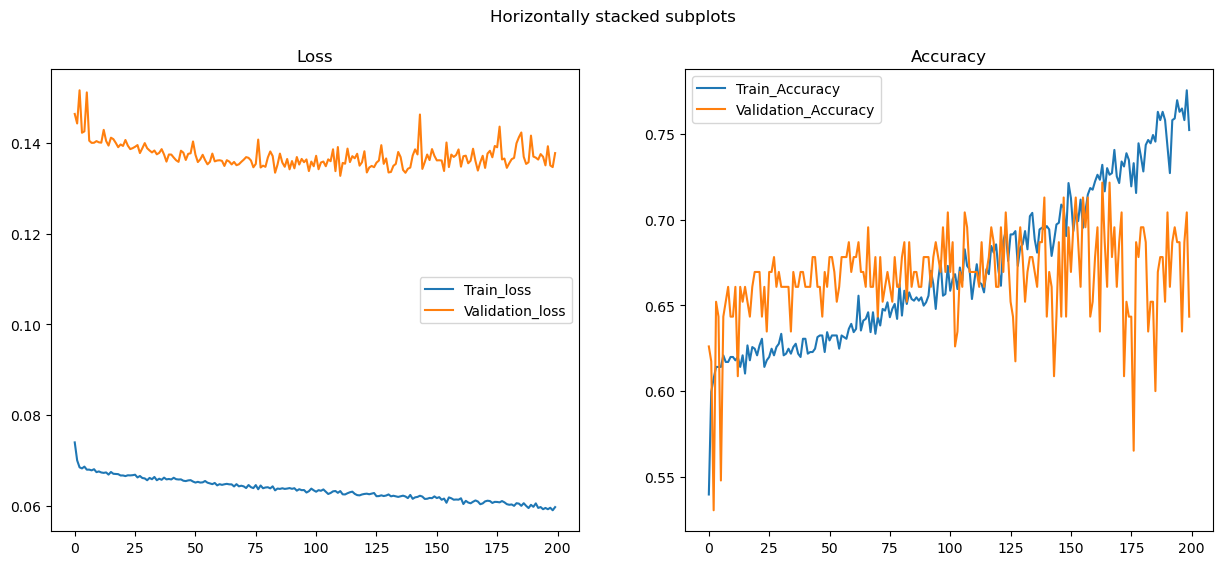

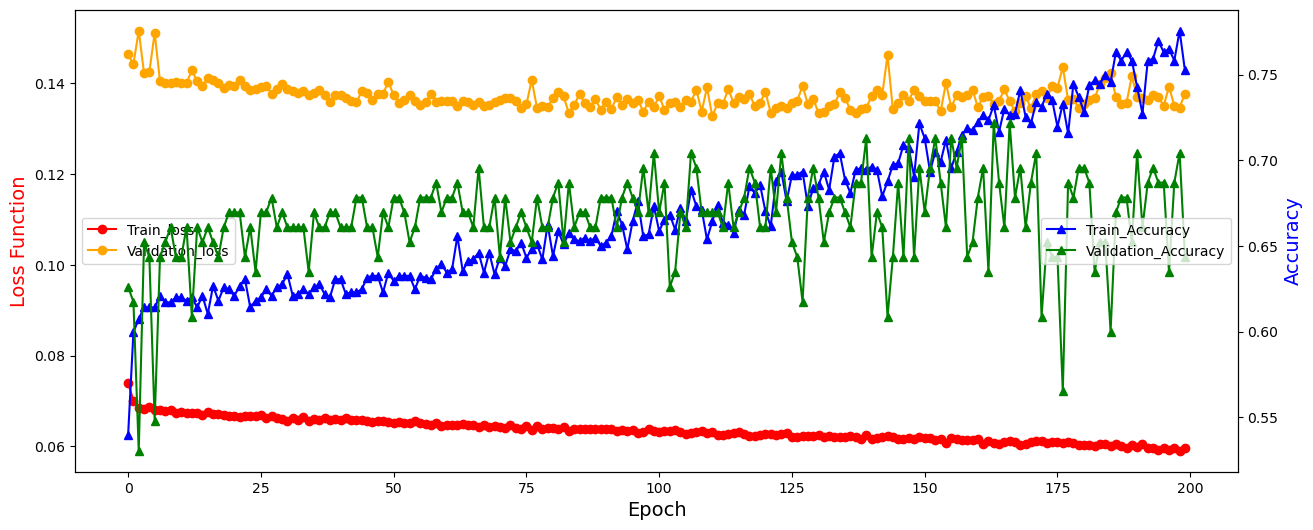

Current time: 68.982 minutes. Time expected till completion: 103.474 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05903624404560436
Val loss:  0.13776334109513655
train accuracy:  0.7736943907156673
Val accuracy:  0.6608695652173913
Current time: 69.309 minutes. Time expected till completion: 103.102 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.05884840340863344
Val loss:  0.13757351947867352
train accuracy:  0.7688588007736944
Val accuracy:  0.6521739130434783
Current time: 69.642 minutes. Time expected till completion: 102.739 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.059241016782690524
Val loss:  0.13821832719056504
train accuracy:  0.7707930367504836
Val accuracy:  0.6608695652173913
Current time: 69.968 minutes. Time expected till completion: 102.367 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05958719335395547
Val loss:  0.1405408112899117
train accuracy:  0.7562862669245648
Val accuracy:  0.6434782608695652
Current time: 70.294 minutes. Time expected till completion: 101.995 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.0592199904083975
Val loss:  0.1361519896465799
train accuracy:  0.7717601547388782
Val accuracy:  0.6608695652173913
Current time: 70.621 minutes. Time expected till completion: 101.625 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.0593514455125687
Val loss:  0.13520603231761766
train accuracy:  0.7659574468085106
Val accuracy:  0.6956521739130435
Current time: 70.951 minutes. Time expected till completion: 101.261 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05909891066283737
Val loss:  0.13609890160353288
train accuracy:  0.7649903288201161
Val accuracy:  0.6347826086956522
Current time: 71.278 minutes. Time expected till completion: 100.891 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.05907480790490569
Val loss:  0.13677777518396791
train accuracy:  0.776595744680851
Val accuracy:  0.6521739130434783
Current time: 71.605 minutes. Time expected till completion: 100.523 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05972425221705114
Val loss:  0.13678782711858334
train accuracy:  0.7495164410058027
Val accuracy:  0.6869565217391305
Current time: 71.932 minutes. Time expected till completion: 100.154 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 15.52it/s]


train loss:  0.059185431416306784
Val loss:  0.1346445047337076
train accuracy:  0.769825918762089
Val accuracy:  0.6869565217391305
Current time: 72.260 minutes. Time expected till completion: 99.788 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05862640942549567
Val loss:  0.13367878613264664
train accuracy:  0.7804642166344294
Val accuracy:  0.6521739130434783
Current time: 72.588 minutes. Time expected till completion: 99.421 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.058592986322694406
Val loss:  0.13574696675590847
train accuracy:  0.7920696324951644
Val accuracy:  0.6521739130434783
Current time: 72.916 minutes. Time expected till completion: 99.056 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05836811557959772
Val loss:  0.14004604349965635
train accuracy:  0.7843326885880078
Val accuracy:  0.6608695652173913
Current time: 73.242 minutes. Time expected till completion: 98.687 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.05823966849242234
Val loss:  0.137289501791415
train accuracy:  0.7804642166344294
Val accuracy:  0.6521739130434783
Current time: 73.568 minutes. Time expected till completion: 98.320 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.05909552121070183
Val loss:  0.1403739219126494
train accuracy:  0.7775628626692457
Val accuracy:  0.5739130434782609
Current time: 73.895 minutes. Time expected till completion: 97.954 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05884292231768197
Val loss:  0.14015342670938244
train accuracy:  0.7823984526112185
Val accuracy:  0.6086956521739131
Current time: 74.226 minutes. Time expected till completion: 97.593 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05868354030457871
Val loss:  0.13814712192701256
train accuracy:  0.7872340425531915
Val accuracy:  0.6695652173913044
Current time: 74.553 minutes. Time expected till completion: 97.228 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05806671051268882
Val loss:  0.13641477356786313
train accuracy:  0.7998065764023211
Val accuracy:  0.6434782608695652
Current time: 74.881 minutes. Time expected till completion: 96.864 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 15.73it/s]


train loss:  0.05852991872876018
Val loss:  0.1371449185454327
train accuracy:  0.7852998065764023
Val accuracy:  0.591304347826087
Current time: 75.208 minutes. Time expected till completion: 96.499 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.05792566741919379
Val loss:  0.13739261627197266
train accuracy:  0.7940038684719536
Val accuracy:  0.6260869565217392
Current time: 75.535 minutes. Time expected till completion: 96.136 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05935253643897331
Val loss:  0.1352379296136939
train accuracy:  0.7756286266924565
Val accuracy:  0.6869565217391305
Current time: 75.862 minutes. Time expected till completion: 95.772 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05848986838495708
Val loss:  0.13897613753443178
train accuracy:  0.7920696324951644
Val accuracy:  0.6173913043478261
Current time: 76.190 minutes. Time expected till completion: 95.409 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.05800298507716255
Val loss:  0.13405903525974439
train accuracy:  0.7940038684719536
Val accuracy:  0.6782608695652174
Current time: 76.516 minutes. Time expected till completion: 95.045 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05844282723487692
Val loss:  0.13702372986337413
train accuracy:  0.7843326885880078
Val accuracy:  0.6695652173913044
Current time: 76.850 minutes. Time expected till completion: 94.690 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.058883687628998746
Val loss:  0.14166598423667576
train accuracy:  0.7901353965183753
Val accuracy:  0.6173913043478261
Current time: 77.181 minutes. Time expected till completion: 94.333 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05856564254779188
Val loss:  0.13845377953156182
train accuracy:  0.7882011605415861
Val accuracy:  0.6347826086956522
Current time: 77.507 minutes. Time expected till completion: 93.968 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.05785002301463306
Val loss:  0.13691581850466522
train accuracy:  0.8036750483558994
Val accuracy:  0.6521739130434783
Current time: 77.832 minutes. Time expected till completion: 93.605 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.05778900607411589
Val loss:  0.1396187813385673
train accuracy:  0.8085106382978723
Val accuracy:  0.6434782608695652
Current time: 78.160 minutes. Time expected till completion: 93.244 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05802516987983217
Val loss:  0.13873156464618186
train accuracy:  0.793036750483559
Val accuracy:  0.6173913043478261
Current time: 78.491 minutes. Time expected till completion: 92.887 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.057641417133969544
Val loss:  0.14399736290392667
train accuracy:  0.8027079303675049
Val accuracy:  0.5826086956521739
Current time: 78.816 minutes. Time expected till completion: 92.524 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05722013064002622
Val loss:  0.13610235245331473
train accuracy:  0.8210831721470019
Val accuracy:  0.6782608695652174
Current time: 79.144 minutes. Time expected till completion: 92.163 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05800130115948055
Val loss:  0.1415457274602807
train accuracy:  0.7998065764023211
Val accuracy:  0.6173913043478261
Current time: 79.474 minutes. Time expected till completion: 91.806 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05780826367769297
Val loss:  0.138231477011805
train accuracy:  0.8056092843326886
Val accuracy:  0.6521739130434783
Current time: 79.801 minutes. Time expected till completion: 91.446 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.057198813390455114
Val loss:  0.135522983385169
train accuracy:  0.8220502901353965
Val accuracy:  0.6695652173913044
Current time: 80.127 minutes. Time expected till completion: 91.085 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.056928645538407555
Val loss:  0.1358651156010835
train accuracy:  0.8210831721470019
Val accuracy:  0.6695652173913044
Current time: 80.453 minutes. Time expected till completion: 90.723 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


train loss:  0.05789107718366258
Val loss:  0.14088580660198047
train accuracy:  0.7978723404255319
Val accuracy:  0.6260869565217392
Current time: 80.786 minutes. Time expected till completion: 90.371 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 15.33it/s]


train loss:  0.05774509774185933
Val loss:  0.13557233032972915
train accuracy:  0.7978723404255319
Val accuracy:  0.6782608695652174
Current time: 81.125 minutes. Time expected till completion: 90.025 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.056778202435034154
Val loss:  0.1344154311263043
train accuracy:  0.8259187620889749
Val accuracy:  0.6434782608695652
Current time: 81.452 minutes. Time expected till completion: 89.666 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05668163605077585
Val loss:  0.13951067613518756
train accuracy:  0.8152804642166345
Val accuracy:  0.6521739130434783
Current time: 81.783 minutes. Time expected till completion: 89.311 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:01<00:00, 14.83it/s]


train loss:  0.05724240923066204
Val loss:  0.1361810362857321
train accuracy:  0.8201160541586073
Val accuracy:  0.6782608695652174
Current time: 82.114 minutes. Time expected till completion: 88.956 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 15.09it/s]


train loss:  0.05766149974883871
Val loss:  0.1370873440866885
train accuracy:  0.8075435203094777
Val accuracy:  0.6869565217391305
Current time: 82.446 minutes. Time expected till completion: 88.603 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.057457121762823554
Val loss:  0.1382307892260344
train accuracy:  0.8036750483558994
Val accuracy:  0.6782608695652174
Current time: 82.783 minutes. Time expected till completion: 88.257 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05677499698485811
Val loss:  0.13722565381423288
train accuracy:  0.8268858800773694
Val accuracy:  0.6782608695652174
Current time: 83.110 minutes. Time expected till completion: 87.898 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:01<00:00, 14.52it/s]


train loss:  0.056706485884332566
Val loss:  0.13814388254414434
train accuracy:  0.8085106382978723
Val accuracy:  0.6434782608695652
Current time: 83.475 minutes. Time expected till completion: 87.580 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 15.51it/s]


train loss:  0.05682208793997995
Val loss:  0.140753422094428
train accuracy:  0.8172147001934236
Val accuracy:  0.6173913043478261
Current time: 83.840 minutes. Time expected till completion: 87.262 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05698347731531243
Val loss:  0.13434801930966583
train accuracy:  0.8191489361702128
Val accuracy:  0.6695652173913044
Current time: 84.177 minutes. Time expected till completion: 86.915 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 15.22it/s]


train loss:  0.056950767911840915
Val loss:  0.13890171102855517
train accuracy:  0.816247582205029
Val accuracy:  0.6347826086956522
Current time: 84.509 minutes. Time expected till completion: 86.562 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


train loss:  0.05715912770717702
Val loss:  0.13762356923974078
train accuracy:  0.8230174081237911
Val accuracy:  0.6869565217391305
Current time: 84.840 minutes. Time expected till completion: 86.208 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 15.33it/s]


train loss:  0.056866562746940776
Val loss:  0.1363793238349583
train accuracy:  0.8268858800773694
Val accuracy:  0.6695652173913044
Current time: 85.177 minutes. Time expected till completion: 85.861 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.05620707764616326
Val loss:  0.14138741545055222
train accuracy:  0.8365570599613152
Val accuracy:  0.6608695652173913
Current time: 85.514 minutes. Time expected till completion: 85.514 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05654321584987456
Val loss:  0.1395523154217264
train accuracy:  0.8210831721470019
Val accuracy:  0.6608695652173913
Current time: 85.841 minutes. Time expected till completion: 85.157 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 15.63it/s]


train loss:  0.05673286226547433
Val loss:  0.13717777366223544
train accuracy:  0.8220502901353965
Val accuracy:  0.6782608695652174
Current time: 86.169 minutes. Time expected till completion: 84.802 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.05595449777590237
Val loss:  0.13797030811724456
train accuracy:  0.8384912959381045
Val accuracy:  0.6608695652173913
Current time: 86.498 minutes. Time expected till completion: 84.447 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05678955464114073
Val loss:  0.13974766161130822
train accuracy:  0.8297872340425532
Val accuracy:  0.6434782608695652
Current time: 86.823 minutes. Time expected till completion: 84.089 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.05626294212830136
Val loss:  0.13911921200544938
train accuracy:  0.8288201160541586
Val accuracy:  0.6
Current time: 87.153 minutes. Time expected till completion: 83.736 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.05677232209672319
Val loss:  0.14102338863455732
train accuracy:  0.8201160541586073
Val accuracy:  0.6173913043478261
Current time: 87.497 minutes. Time expected till completion: 83.396 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.056798835326440096
Val loss:  0.13851206976434458
train accuracy:  0.8249516441005803
Val accuracy:  0.6347826086956522
Current time: 87.824 minutes. Time expected till completion: 83.040 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.05679679729721763
Val loss:  0.13454571444055308
train accuracy:  0.8230174081237911
Val accuracy:  0.6347826086956522
Current time: 88.149 minutes. Time expected till completion: 82.682 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.055529030944208115
Val loss:  0.1474097464395606
train accuracy:  0.8452611218568665
Val accuracy:  0.5826086956521739
Current time: 88.481 minutes. Time expected till completion: 82.332 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05662775892814769
Val loss:  0.13858160506124081
train accuracy:  0.8268858800773694
Val accuracy:  0.6173913043478261
Current time: 88.815 minutes. Time expected till completion: 81.983 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.05605776460996218
Val loss:  0.13886771409407905
train accuracy:  0.8433268858800773
Val accuracy:  0.6434782608695652
Current time: 89.149 minutes. Time expected till completion: 81.634 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.05665531212633306
Val loss:  0.14510046710138735
train accuracy:  0.8239845261121856
Val accuracy:  0.6
Current time: 89.477 minutes. Time expected till completion: 81.280 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.05604397184152437
Val loss:  0.13944230131481006
train accuracy:  0.8539651837524178
Val accuracy:  0.6347826086956522
Current time: 89.807 minutes. Time expected till completion: 80.929 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.055890837536559115
Val loss:  0.14255485793818598
train accuracy:  0.8462282398452611
Val accuracy:  0.6173913043478261
Current time: 90.138 minutes. Time expected till completion: 80.578 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.0558123281315632
Val loss:  0.14050736686457757
train accuracy:  0.8433268858800773
Val accuracy:  0.6347826086956522
Current time: 90.463 minutes. Time expected till completion: 80.222 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.055604913997926844
Val loss:  0.1364455186802408
train accuracy:  0.8413926499032882
Val accuracy:  0.6521739130434783
Current time: 90.798 minutes. Time expected till completion: 79.875 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.05562380578808443
Val loss:  0.14048378934030947
train accuracy:  0.8529980657640233
Val accuracy:  0.6173913043478261
Current time: 91.124 minutes. Time expected till completion: 79.520 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


train loss:  0.05583789944648743
Val loss:  0.13826032565987628
train accuracy:  0.8375241779497099
Val accuracy:  0.6521739130434783
Current time: 91.461 minutes. Time expected till completion: 79.175 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05652828304172715
Val loss:  0.13656052610148553
train accuracy:  0.8384912959381045
Val accuracy:  0.6434782608695652
Current time: 91.790 minutes. Time expected till completion: 78.824 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.055292030079452395
Val loss:  0.1359119581139606
train accuracy:  0.8500967117988395
Val accuracy:  0.6608695652173913
Current time: 92.119 minutes. Time expected till completion: 78.472 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.0560145442674884
Val loss:  0.13936460432798967
train accuracy:  0.839458413926499
Val accuracy:  0.6173913043478261
Current time: 92.449 minutes. Time expected till completion: 78.121 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.05512609420708116
Val loss:  0.136655142514602
train accuracy:  0.8529980657640233
Val accuracy:  0.6695652173913044
Current time: 92.780 minutes. Time expected till completion: 77.772 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05517832857036037
Val loss:  0.14254386735999067
train accuracy:  0.8491295938104448
Val accuracy:  0.6173913043478261
Current time: 93.110 minutes. Time expected till completion: 77.421 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05517500004869826
Val loss:  0.15425474125406016
train accuracy:  0.8520309477756286
Val accuracy:  0.5304347826086957
Current time: 93.436 minutes. Time expected till completion: 77.067 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05576748215022355
Val loss:  0.13415549008742622
train accuracy:  0.8452611218568665
Val accuracy:  0.7304347826086957
Current time: 93.760 minutes. Time expected till completion: 76.713 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.05525114377185962
Val loss:  0.13953924127247022
train accuracy:  0.8413926499032882
Val accuracy:  0.6260869565217392
Current time: 94.099 minutes. Time expected till completion: 76.370 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.05585584586316889
Val loss:  0.14613224734430727
train accuracy:  0.8346228239845261
Val accuracy:  0.5739130434782609
Current time: 94.482 minutes. Time expected till completion: 76.063 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


train loss:  0.054991031350204056
Val loss:  0.14024860496106356
train accuracy:  0.8597678916827853
Val accuracy:  0.6173913043478261
Current time: 94.833 minutes. Time expected till completion: 75.730 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.05555183392889956
Val loss:  0.1406500474266384
train accuracy:  0.8462282398452611
Val accuracy:  0.6260869565217392
Current time: 95.164 minutes. Time expected till completion: 75.381 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.05482521653175354
Val loss:  0.13886533768280693
train accuracy:  0.8520309477756286
Val accuracy:  0.6521739130434783
Current time: 95.498 minutes. Time expected till completion: 75.034 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.054856144425025066
Val loss:  0.13940803382707678
train accuracy:  0.8626692456479691
Val accuracy:  0.6608695652173913
Current time: 95.824 minutes. Time expected till completion: 74.681 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.05557110421431595
Val loss:  0.13895357225252233
train accuracy:  0.8452611218568665
Val accuracy:  0.6347826086956522
Current time: 96.159 minutes. Time expected till completion: 74.336 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.05403981120028394
Val loss:  0.13627480112988016
train accuracy:  0.8752417794970987
Val accuracy:  0.6695652173913044
Current time: 96.490 minutes. Time expected till completion: 73.987 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.05466214906085621
Val loss:  0.1350168181502301
train accuracy:  0.8588007736943907
Val accuracy:  0.6956521739130435
Current time: 96.835 minutes. Time expected till completion: 73.649 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.05441321591113476
Val loss:  0.13908759977506555
train accuracy:  0.8723404255319149
Val accuracy:  0.6434782608695652
Current time: 97.165 minutes. Time expected till completion: 73.300 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.054443844167130134
Val loss:  0.1397960864979288
train accuracy:  0.8694390715667312
Val accuracy:  0.6521739130434783
Current time: 97.491 minutes. Time expected till completion: 72.947 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.05436590042981235
Val loss:  0.13795067901196686
train accuracy:  0.8588007736943907
Val accuracy:  0.6608695652173913
Current time: 97.821 minutes. Time expected till completion: 72.599 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 15.52it/s]


train loss:  0.05444062695743037
Val loss:  0.13463913824247278
train accuracy:  0.8626692456479691
Val accuracy:  0.6956521739130435
Current time: 98.162 minutes. Time expected till completion: 72.258 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.05466679937604318
Val loss:  0.1435309130212535
train accuracy:  0.8617021276595744
Val accuracy:  0.6173913043478261
Current time: 98.493 minutes. Time expected till completion: 71.910 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.05442551717997981
Val loss:  0.1368011702661929
train accuracy:  0.8626692456479691
Val accuracy:  0.6782608695652174
Current time: 98.819 minutes. Time expected till completion: 71.558 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05408087528420601
Val loss:  0.1380801999050638
train accuracy:  0.8829787234042553
Val accuracy:  0.6695652173913044
Current time: 99.152 minutes. Time expected till completion: 71.212 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.054461356173170376
Val loss:  0.1387512056723885
train accuracy:  0.874274661508704
Val accuracy:  0.6260869565217392
Current time: 99.491 minutes. Time expected till completion: 70.871 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.05411809999892052
Val loss:  0.13832723057788351
train accuracy:  0.8694390715667312
Val accuracy:  0.6260869565217392
Current time: 99.825 minutes. Time expected till completion: 70.525 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:01<00:00, 14.92it/s]


train loss:  0.05440260807135119
Val loss:  0.13467954967332924
train accuracy:  0.8626692456479691
Val accuracy:  0.6608695652173913
Current time: 100.160 minutes. Time expected till completion: 70.180 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.054038373194995194
Val loss:  0.13671480054440704
train accuracy:  0.8752417794970987
Val accuracy:  0.6434782608695652
Current time: 100.499 minutes. Time expected till completion: 69.838 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


train loss:  0.05469948600984865
Val loss:  0.14512627280276755
train accuracy:  0.8491295938104448
Val accuracy:  0.6086956521739131
Current time: 100.842 minutes. Time expected till completion: 69.500 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.05437749191916888
Val loss:  0.13757389472878498
train accuracy:  0.8704061895551257
Val accuracy:  0.6608695652173913
Current time: 101.173 minutes. Time expected till completion: 69.152 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.05457477234087783
Val loss:  0.14045401759769605
train accuracy:  0.867504835589942
Val accuracy:  0.6260869565217392
Current time: 101.508 minutes. Time expected till completion: 68.808 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.05461932542937406
Val loss:  0.1380524930746659
train accuracy:  0.8588007736943907
Val accuracy:  0.6695652173913044
Current time: 101.834 minutes. Time expected till completion: 68.457 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:01<00:00, 14.32it/s]


train loss:  0.053673908662058165
Val loss:  0.13952164857283883
train accuracy:  0.8762088974854932
Val accuracy:  0.6260869565217392
Saving model checkpoint


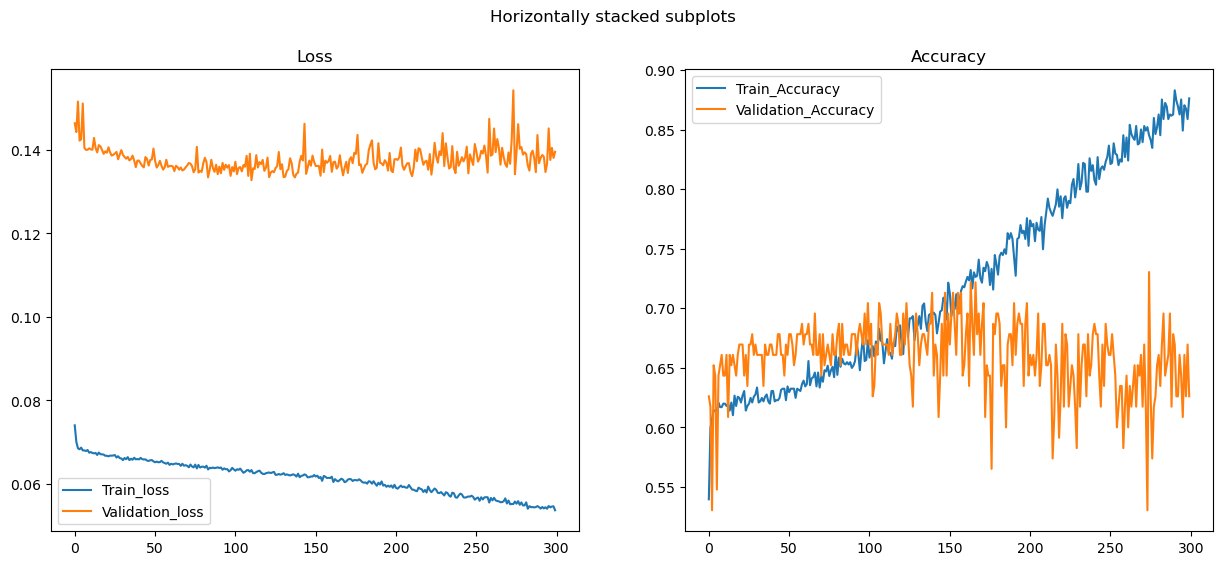

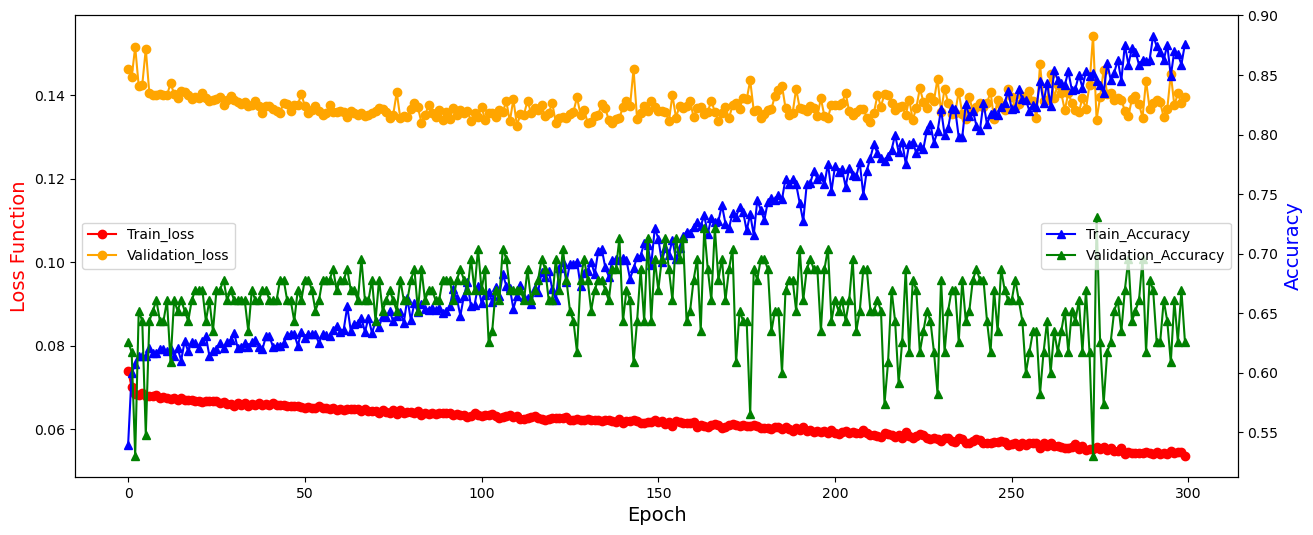

Current time: 102.190 minutes. Time expected till completion: 68.127 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05392322117170928
Val loss:  0.1388883290083512
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Current time: 102.520 minutes. Time expected till completion: 67.779 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.054180770708928946
Val loss:  0.14174805879592894
train accuracy:  0.8781431334622823
Val accuracy:  0.6521739130434783
Current time: 102.853 minutes. Time expected till completion: 67.433 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.054523367715758095
Val loss:  0.13951952146447222
train accuracy:  0.8723404255319149
Val accuracy:  0.6608695652173913
Current time: 103.191 minutes. Time expected till completion: 67.091 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.054220597506491774
Val loss:  0.13957206684610118
train accuracy:  0.8781431334622823
Val accuracy:  0.6347826086956522
Current time: 103.523 minutes. Time expected till completion: 66.745 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.05379554416040387
Val loss:  0.14252616218898606
train accuracy:  0.8858800773694391
Val accuracy:  0.6086956521739131
Current time: 103.853 minutes. Time expected till completion: 66.398 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.054132009497924745
Val loss:  0.1485622224600419
train accuracy:  0.8829787234042553
Val accuracy:  0.6
Current time: 104.188 minutes. Time expected till completion: 66.054 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


train loss:  0.054726320205389645
Val loss:  0.14235488901967588
train accuracy:  0.8558994197292069
Val accuracy:  0.6260869565217392
Current time: 104.520 minutes. Time expected till completion: 65.708 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.05329146987003791
Val loss:  0.14130715650060902
train accuracy:  0.8810444874274661
Val accuracy:  0.6173913043478261
Current time: 104.850 minutes. Time expected till completion: 65.361 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.053661788282357514
Val loss:  0.13779262511626533
train accuracy:  0.8839458413926499
Val accuracy:  0.6608695652173913
Current time: 105.183 minutes. Time expected till completion: 65.016 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.054081255220582915
Val loss:  0.14150552956954293
train accuracy:  0.8733075435203095
Val accuracy:  0.6086956521739131
Current time: 105.514 minutes. Time expected till completion: 64.670 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.05412430626050185
Val loss:  0.1434723304665607
train accuracy:  0.8771760154738878
Val accuracy:  0.591304347826087
Current time: 105.852 minutes. Time expected till completion: 64.328 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.05450431763318798
Val loss:  0.13928635016731594
train accuracy:  0.8733075435203095
Val accuracy:  0.6347826086956522
Current time: 106.185 minutes. Time expected till completion: 63.983 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.05336444803317234
Val loss:  0.13841587201408717
train accuracy:  0.8839458413926499
Val accuracy:  0.6608695652173913
Current time: 106.519 minutes. Time expected till completion: 63.639 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.053816968283293555
Val loss:  0.13870255843452786
train accuracy:  0.874274661508704
Val accuracy:  0.6347826086956522
Current time: 106.850 minutes. Time expected till completion: 63.293 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.05332530103984147
Val loss:  0.14032784959544306
train accuracy:  0.8897485493230174
Val accuracy:  0.6173913043478261
Current time: 107.182 minutes. Time expected till completion: 62.948 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:01<00:00, 14.04it/s]


train loss:  0.054035817573794546
Val loss:  0.14090547976286516
train accuracy:  0.8752417794970987
Val accuracy:  0.591304347826087
Current time: 107.535 minutes. Time expected till completion: 62.615 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.053356485913293276
Val loss:  0.14139213406521342
train accuracy:  0.8878143133462283
Val accuracy:  0.6173913043478261
Current time: 107.939 minutes. Time expected till completion: 62.312 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


train loss:  0.05362742090132988
Val loss:  0.13934455280718597
train accuracy:  0.8858800773694391
Val accuracy:  0.6347826086956522
Current time: 108.296 minutes. Time expected till completion: 61.980 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05278829875721
Val loss:  0.14054233716881792
train accuracy:  0.9003868471953579
Val accuracy:  0.6434782608695652
Current time: 108.637 minutes. Time expected till completion: 61.640 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.053487006135328134
Val loss:  0.13706505972406138
train accuracy:  0.8800773694390716
Val accuracy:  0.6782608695652174
Current time: 108.983 minutes. Time expected till completion: 61.303 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.05299053426176252
Val loss:  0.13786666807921036
train accuracy:  0.8936170212765957
Val accuracy:  0.6695652173913044
Current time: 109.320 minutes. Time expected till completion: 60.960 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.05342067925104551
Val loss:  0.1409400198770606
train accuracy:  0.8916827852998066
Val accuracy:  0.6521739130434783
Current time: 109.667 minutes. Time expected till completion: 60.623 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 15.76it/s]


train loss:  0.053407135277237144
Val loss:  0.14157262366750967
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Current time: 110.025 minutes. Time expected till completion: 60.292 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.05364784119899314
Val loss:  0.14283946700718092
train accuracy:  0.8781431334622823
Val accuracy:  0.6086956521739131
Current time: 110.369 minutes. Time expected till completion: 59.954 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.0539753784639923
Val loss:  0.14021849321282429
train accuracy:  0.8810444874274661
Val accuracy:  0.6260869565217392
Current time: 110.720 minutes. Time expected till completion: 59.619 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 15.52it/s]


train loss:  0.0538273156842134
Val loss:  0.1368083699889805
train accuracy:  0.8762088974854932
Val accuracy:  0.7043478260869566
Current time: 111.070 minutes. Time expected till completion: 59.283 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:01<00:00, 14.91it/s]


train loss:  0.05271263204414102
Val loss:  0.13964521055636198
train accuracy:  0.90715667311412
Val accuracy:  0.6521739130434783
Current time: 111.416 minutes. Time expected till completion: 58.945 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.05346949378341955
Val loss:  0.14562188490577366
train accuracy:  0.8820116054158608
Val accuracy:  0.591304347826087
Current time: 111.759 minutes. Time expected till completion: 58.605 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


train loss:  0.053565934963336996
Val loss:  0.13705612680186396
train accuracy:  0.8849129593810445
Val accuracy:  0.6347826086956522
Current time: 112.094 minutes. Time expected till completion: 58.262 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05312253134163021
Val loss:  0.14021186258481896
train accuracy:  0.8907156673114119
Val accuracy:  0.6434782608695652
Current time: 112.444 minutes. Time expected till completion: 57.926 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


train loss:  0.053383161643487574
Val loss:  0.1416365245114202
train accuracy:  0.8907156673114119
Val accuracy:  0.6260869565217392
Current time: 112.778 minutes. Time expected till completion: 57.581 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.05301105024966788
Val loss:  0.14525339551593947
train accuracy:  0.8936170212765957
Val accuracy:  0.6
Current time: 113.118 minutes. Time expected till completion: 57.240 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.05309475033149498
Val loss:  0.1396776328916135
train accuracy:  0.8887814313346228
Val accuracy:  0.6347826086956522
Current time: 113.475 minutes. Time expected till completion: 56.908 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.0533347866521352
Val loss:  0.13995021270669025
train accuracy:  0.8839458413926499
Val accuracy:  0.6173913043478261
Current time: 113.823 minutes. Time expected till completion: 56.571 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.05304525587959954
Val loss:  0.1402662614117498
train accuracy:  0.8945841392649904
Val accuracy:  0.6347826086956522
Current time: 114.169 minutes. Time expected till completion: 56.232 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.05275942313140781
Val loss:  0.13806293580843054
train accuracy:  0.8936170212765957
Val accuracy:  0.6608695652173913
Current time: 114.512 minutes. Time expected till completion: 55.893 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.052887350897263284
Val loss:  0.14069238123686417
train accuracy:  0.8926499032882012
Val accuracy:  0.6347826086956522
Current time: 114.855 minutes. Time expected till completion: 55.553 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


train loss:  0.05276456492551291
Val loss:  0.1427360265151314
train accuracy:  0.8974854932301741
Val accuracy:  0.6173913043478261
Current time: 115.207 minutes. Time expected till completion: 55.218 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 15.69it/s]


train loss:  0.05220833755092879
Val loss:  0.14016368907430898
train accuracy:  0.9042553191489362
Val accuracy:  0.6434782608695652
Current time: 115.547 minutes. Time expected till completion: 54.876 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.052822173218201394
Val loss:  0.14312975562137106
train accuracy:  0.8994197292069632
Val accuracy:  0.6086956521739131
Current time: 115.892 minutes. Time expected till completion: 54.538 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.05282755717779267
Val loss:  0.14532426336537238
train accuracy:  0.8994197292069632
Val accuracy:  0.5826086956521739
Current time: 116.246 minutes. Time expected till completion: 54.203 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05249353897410158
Val loss:  0.13938441743021426
train accuracy:  0.90715667311412
Val accuracy:  0.6347826086956522
Current time: 116.593 minutes. Time expected till completion: 53.865 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05231899824317696
Val loss:  0.14622532699419105
train accuracy:  0.9129593810444874
Val accuracy:  0.591304347826087
Current time: 116.927 minutes. Time expected till completion: 53.521 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.052979455983385125
Val loss:  0.13936029828113058
train accuracy:  0.8897485493230174
Val accuracy:  0.6260869565217392
Current time: 117.265 minutes. Time expected till completion: 53.178 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


train loss:  0.05288530335666133
Val loss:  0.14757921903029733
train accuracy:  0.8984526112185687
Val accuracy:  0.5478260869565217
Current time: 117.613 minutes. Time expected till completion: 52.841 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 16.01it/s]


train loss:  0.052387361196761434
Val loss:  0.14339143970738286
train accuracy:  0.9013539651837524
Val accuracy:  0.6173913043478261
Current time: 117.952 minutes. Time expected till completion: 52.499 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.05250611993514823
Val loss:  0.14297009395516436
train accuracy:  0.8994197292069632
Val accuracy:  0.5652173913043478
Current time: 118.280 minutes. Time expected till completion: 52.152 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


train loss:  0.05279752756225763
Val loss:  0.13915746626646622
train accuracy:  0.8955512572533849
Val accuracy:  0.6347826086956522
Current time: 118.627 minutes. Time expected till completion: 51.814 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.05308521623998823
Val loss:  0.15096636440442956
train accuracy:  0.8955512572533849
Val accuracy:  0.5130434782608696
Current time: 118.973 minutes. Time expected till completion: 51.475 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.05223493459607462
Val loss:  0.13883290705473528
train accuracy:  0.90715667311412
Val accuracy:  0.6521739130434783
Current time: 119.306 minutes. Time expected till completion: 51.131 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 15.32it/s]


train loss:  0.0524034795263058
Val loss:  0.14100227200466653
train accuracy:  0.8974854932301741
Val accuracy:  0.6608695652173913
Current time: 119.649 minutes. Time expected till completion: 50.791 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


train loss:  0.05295302293747952
Val loss:  0.1428833298061205
train accuracy:  0.8955512572533849
Val accuracy:  0.6434782608695652
Current time: 120.012 minutes. Time expected till completion: 50.459 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:01<00:00, 14.26it/s]


train loss:  0.05251027813732509
Val loss:  0.140027305872544
train accuracy:  0.9003868471953579
Val accuracy:  0.6608695652173913
Current time: 120.365 minutes. Time expected till completion: 50.124 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.05275982036120195
Val loss:  0.14462564613508141
train accuracy:  0.9042553191489362
Val accuracy:  0.6
Current time: 120.697 minutes. Time expected till completion: 49.779 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.05225529142689659
Val loss:  0.1422647942667422
train accuracy:  0.9052224371373307
Val accuracy:  0.6260869565217392
Current time: 121.041 minutes. Time expected till completion: 49.439 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.05222133044117424
Val loss:  0.14721613396768984
train accuracy:  0.9081237911025145
Val accuracy:  0.5652173913043478
Current time: 121.391 minutes. Time expected till completion: 49.102 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


train loss:  0.05216542889347851
Val loss:  0.139046355434086
train accuracy:  0.9206963249516441
Val accuracy:  0.6347826086956522
Current time: 121.730 minutes. Time expected till completion: 48.760 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.052124431908015356
Val loss:  0.15055412261382392
train accuracy:  0.9110251450676983
Val accuracy:  0.5565217391304348
Current time: 122.077 minutes. Time expected till completion: 48.421 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 15.66it/s]


train loss:  0.051680247834388245
Val loss:  0.13734427638675856
train accuracy:  0.913926499032882
Val accuracy:  0.6608695652173913
Current time: 122.417 minutes. Time expected till completion: 48.080 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 15.99it/s]


train loss:  0.052188715920918685
Val loss:  0.144587256597436
train accuracy:  0.9110251450676983
Val accuracy:  0.5739130434782609
Current time: 122.752 minutes. Time expected till completion: 47.737 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.05214247355378112
Val loss:  0.14612520933151246
train accuracy:  0.9090909090909091
Val accuracy:  0.5652173913043478
Current time: 123.099 minutes. Time expected till completion: 47.398 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


train loss:  0.05251115012906737
Val loss:  0.14119860089343528
train accuracy:  0.8926499032882012
Val accuracy:  0.6347826086956522
Current time: 123.447 minutes. Time expected till completion: 47.060 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 15.13it/s]


train loss:  0.05196219953623685
Val loss:  0.13776420043862384
train accuracy:  0.913926499032882
Val accuracy:  0.6782608695652174
Current time: 123.804 minutes. Time expected till completion: 46.725 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.05163332860289967
Val loss:  0.14623469010643336
train accuracy:  0.9235976789168279
Val accuracy:  0.5826086956521739
Current time: 124.142 minutes. Time expected till completion: 46.383 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.051984955598122835
Val loss:  0.14210961435152136
train accuracy:  0.9110251450676983
Val accuracy:  0.6173913043478261
Current time: 124.481 minutes. Time expected till completion: 46.041 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 15.56it/s]


train loss:  0.05147649950169502
Val loss:  0.14224983661071114
train accuracy:  0.9197292069632496
Val accuracy:  0.6347826086956522
Current time: 124.817 minutes. Time expected till completion: 45.698 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


train loss:  0.05134111296969179
Val loss:  0.1391160529592763
train accuracy:  0.9245647969052224
Val accuracy:  0.6608695652173913
Current time: 125.157 minutes. Time expected till completion: 45.357 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 15.74it/s]


train loss:  0.05187461460351483
Val loss:  0.13778947747271994
train accuracy:  0.9061895551257253
Val accuracy:  0.6521739130434783
Current time: 125.506 minutes. Time expected till completion: 45.019 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.05166517616010035
Val loss:  0.14291893243789672
train accuracy:  0.913926499032882
Val accuracy:  0.6260869565217392
Current time: 125.851 minutes. Time expected till completion: 44.679 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 16.06it/s]


train loss:  0.0516649612605687
Val loss:  0.14084881181302278
train accuracy:  0.9226305609284333
Val accuracy:  0.6347826086956522
Current time: 126.201 minutes. Time expected till completion: 44.341 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 15.68it/s]


train loss:  0.05230406872077883
Val loss:  0.14267593311226887
train accuracy:  0.9110251450676983
Val accuracy:  0.591304347826087
Current time: 126.551 minutes. Time expected till completion: 44.003 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


train loss:  0.05153587800621756
Val loss:  0.14915722504906032
train accuracy:  0.9158607350096711
Val accuracy:  0.5565217391304348
Current time: 126.899 minutes. Time expected till completion: 43.664 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 15.56it/s]


train loss:  0.051191503927832185
Val loss:  0.14004641667656276
train accuracy:  0.9197292069632496
Val accuracy:  0.6695652173913044
Current time: 127.257 minutes. Time expected till completion: 43.329 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.0514953294390636
Val loss:  0.13824270652688067
train accuracy:  0.9197292069632496
Val accuracy:  0.6782608695652174
Current time: 127.589 minutes. Time expected till completion: 42.985 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.05188059034384427
Val loss:  0.13946509672247845
train accuracy:  0.9148936170212766
Val accuracy:  0.6173913043478261
Current time: 127.930 minutes. Time expected till completion: 42.643 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:01<00:00, 14.13it/s]


train loss:  0.05158455355716167
Val loss:  0.13887137381926826
train accuracy:  0.9197292069632496
Val accuracy:  0.6434782608695652
Current time: 128.284 minutes. Time expected till completion: 42.306 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.051928860652377576
Val loss:  0.14049954829008682
train accuracy:  0.9110251450676983
Val accuracy:  0.6086956521739131
Current time: 128.637 minutes. Time expected till completion: 41.969 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.051279630605671804
Val loss:  0.13952041968055393
train accuracy:  0.9264990328820116
Val accuracy:  0.6521739130434783
Current time: 128.971 minutes. Time expected till completion: 41.625 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.05221340481040556
Val loss:  0.14446800221567568
train accuracy:  0.9148936170212766
Val accuracy:  0.6
Current time: 129.320 minutes. Time expected till completion: 41.287 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 15.99it/s]


train loss:  0.051415167936273425
Val loss:  0.1428379774093628
train accuracy:  0.9226305609284333
Val accuracy:  0.6260869565217392
Current time: 129.659 minutes. Time expected till completion: 40.945 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:01<00:00, 11.67it/s]


train loss:  0.05202530788499105
Val loss:  0.14165659054465915
train accuracy:  0.9119922630560928
Val accuracy:  0.6521739130434783
Current time: 130.005 minutes. Time expected till completion: 40.605 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.05143296874238167
Val loss:  0.14424309989680414
train accuracy:  0.9274661508704062
Val accuracy:  0.6
Current time: 130.346 minutes. Time expected till completion: 40.264 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.05120991305871443
Val loss:  0.1422000060910764
train accuracy:  0.9313346228239845
Val accuracy:  0.6260869565217392
Current time: 130.693 minutes. Time expected till completion: 39.925 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:01<00:00, 14.34it/s]


train loss:  0.05211487625738177
Val loss:  0.1442931382552437
train accuracy:  0.9110251450676983
Val accuracy:  0.6173913043478261
Current time: 131.037 minutes. Time expected till completion: 39.584 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:01<00:00, 14.30it/s]


train loss:  0.05203611298502068
Val loss:  0.14358187291933142
train accuracy:  0.913926499032882
Val accuracy:  0.6086956521739131
Current time: 131.394 minutes. Time expected till completion: 39.248 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


train loss:  0.051191931882264306
Val loss:  0.14253038841745128
train accuracy:  0.9303675048355899
Val accuracy:  0.6173913043478261
Current time: 131.732 minutes. Time expected till completion: 38.905 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:01<00:00, 12.05it/s]


train loss:  0.05123656498163766
Val loss:  0.1460333482078884
train accuracy:  0.9294003868471954
Val accuracy:  0.5739130434782609
Current time: 132.070 minutes. Time expected till completion: 38.563 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.05129334515021894
Val loss:  0.14530423568642659
train accuracy:  0.9274661508704062
Val accuracy:  0.591304347826087
Current time: 132.406 minutes. Time expected till completion: 38.220 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.05114029206667002
Val loss:  0.14026265610819277
train accuracy:  0.9294003868471954
Val accuracy:  0.6347826086956522
Current time: 132.739 minutes. Time expected till completion: 37.877 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.05151253552455275
Val loss:  0.14360712559326835
train accuracy:  0.913926499032882
Val accuracy:  0.6173913043478261
Current time: 133.076 minutes. Time expected till completion: 37.534 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.05201683537872433
Val loss:  0.13900995980138364
train accuracy:  0.913926499032882
Val accuracy:  0.6521739130434783
Current time: 133.418 minutes. Time expected till completion: 37.193 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05155789321810872
Val loss:  0.1389878661736198
train accuracy:  0.9158607350096711
Val accuracy:  0.6521739130434783
Current time: 133.752 minutes. Time expected till completion: 36.850 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 16.01it/s]


train loss:  0.05174783287242026
Val loss:  0.14254793343336686
train accuracy:  0.9168278529980658
Val accuracy:  0.6086956521739131
Current time: 134.085 minutes. Time expected till completion: 36.507 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.051181403880423686
Val loss:  0.14249394510103308
train accuracy:  0.9294003868471954
Val accuracy:  0.6608695652173913
Current time: 134.415 minutes. Time expected till completion: 36.162 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 16.04it/s]


train loss:  0.05142647817702081
Val loss:  0.13973855246668276
train accuracy:  0.925531914893617
Val accuracy:  0.6521739130434783
Current time: 134.750 minutes. Time expected till completion: 35.820 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.05132574050523326
Val loss:  0.14038571793100107
train accuracy:  0.9264990328820116
Val accuracy:  0.6608695652173913
Current time: 135.088 minutes. Time expected till completion: 35.478 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


train loss:  0.05150018439302131
Val loss:  0.1417546712833902
train accuracy:  0.9216634429400387
Val accuracy:  0.6434782608695652
Current time: 135.420 minutes. Time expected till completion: 35.134 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


train loss:  0.05103586242323457
Val loss:  0.1408473279165185
train accuracy:  0.9274661508704062
Val accuracy:  0.6260869565217392
Current time: 135.754 minutes. Time expected till completion: 34.791 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:01<00:00, 14.54it/s]


train loss:  0.051154095787605415
Val loss:  0.1423303785531417
train accuracy:  0.9294003868471954
Val accuracy:  0.6521739130434783
Current time: 136.093 minutes. Time expected till completion: 34.450 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 15.84it/s]


train loss:  0.05055677977244674
Val loss:  0.14413901671119358
train accuracy:  0.9381044487427466
Val accuracy:  0.6086956521739131
Saving model checkpoint


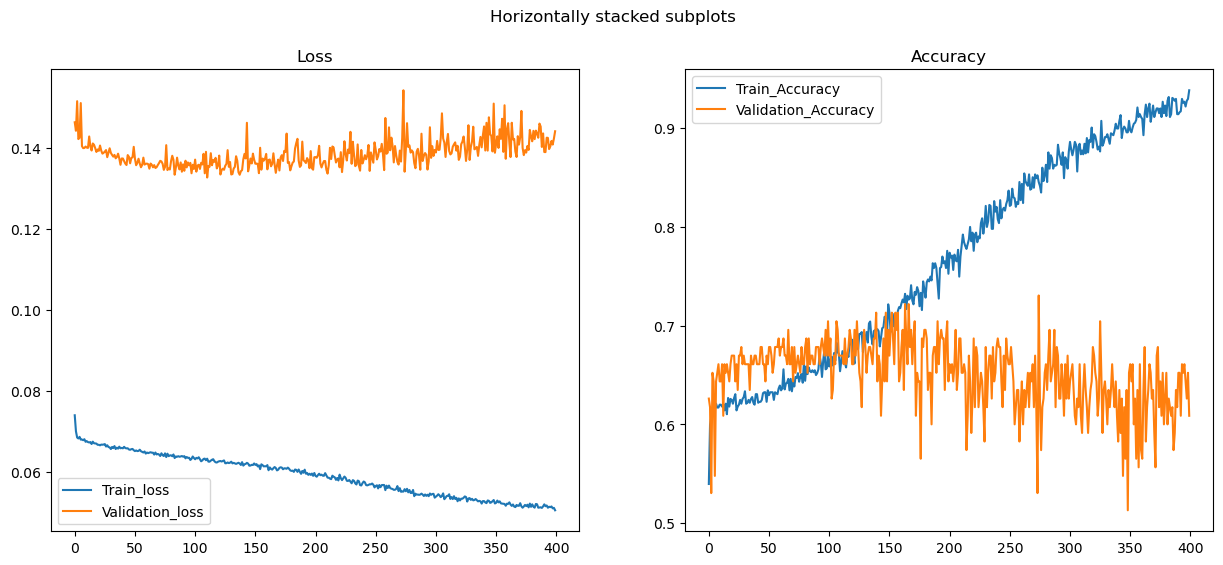

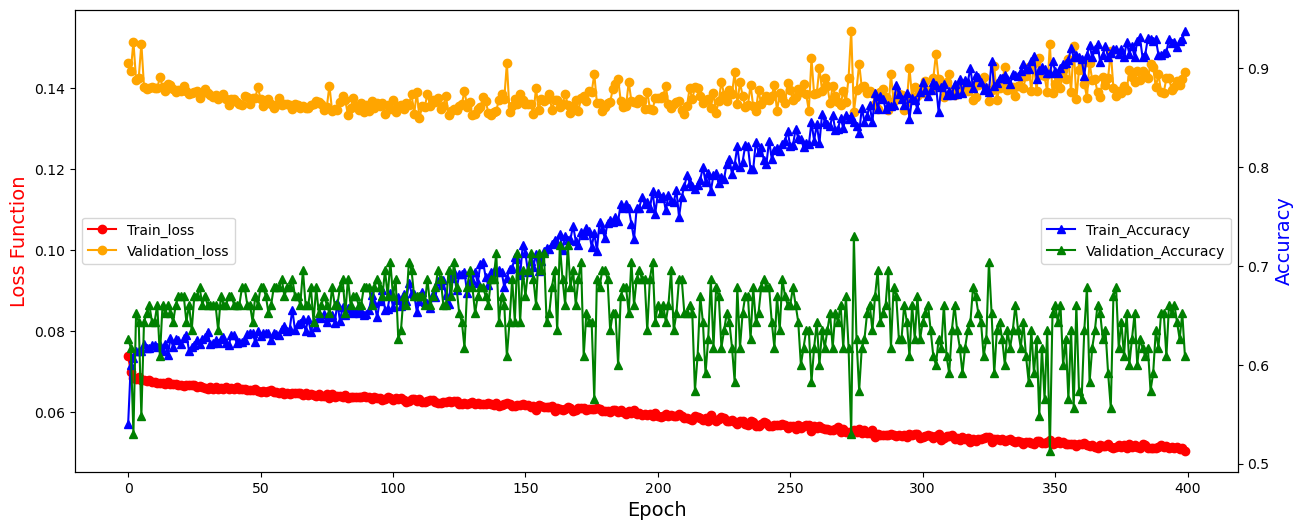

Current time: 136.449 minutes. Time expected till completion: 34.112 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 15.19it/s]


train loss:  0.051206399843356135
Val loss:  0.13988529910211978
train accuracy:  0.9274661508704062
Val accuracy:  0.6521739130434783
Current time: 136.799 minutes. Time expected till completion: 33.773 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.05090339594237809
Val loss:  0.14049399210059124
train accuracy:  0.925531914893617
Val accuracy:  0.6695652173913044
Current time: 137.144 minutes. Time expected till completion: 33.433 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 15.51it/s]


train loss:  0.05117564401958621
Val loss:  0.15280495830204177
train accuracy:  0.9264990328820116
Val accuracy:  0.5217391304347826
Current time: 137.496 minutes. Time expected till completion: 33.094 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  0.05101992659688687
Val loss:  0.1512259094611458
train accuracy:  0.9323017408123792
Val accuracy:  0.5739130434782609
Current time: 137.848 minutes. Time expected till completion: 32.756 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:01<00:00, 14.28it/s]


train loss:  0.051833586835768976
Val loss:  0.14313278094581935
train accuracy:  0.9119922630560928
Val accuracy:  0.6086956521739131
Current time: 138.194 minutes. Time expected till completion: 32.416 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05122076202637914
Val loss:  0.1433366516362066
train accuracy:  0.9216634429400387
Val accuracy:  0.6434782608695652
Current time: 138.534 minutes. Time expected till completion: 32.074 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 15.48it/s]


train loss:  0.05130253239342046
Val loss:  0.14482014593870743
train accuracy:  0.9284332688588007
Val accuracy:  0.6173913043478261
Current time: 138.866 minutes. Time expected till completion: 31.731 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


train loss:  0.05134440263880982
Val loss:  0.13926537969838018
train accuracy:  0.9206963249516441
Val accuracy:  0.6434782608695652
Current time: 139.204 minutes. Time expected till completion: 31.389 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05082906266706824
Val loss:  0.14318376779556274
train accuracy:  0.9313346228239845
Val accuracy:  0.591304347826087
Current time: 139.538 minutes. Time expected till completion: 31.046 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 15.96it/s]


train loss:  0.051072426298831373
Val loss:  0.14724434044050133
train accuracy:  0.9284332688588007
Val accuracy:  0.5826086956521739
Current time: 139.873 minutes. Time expected till completion: 30.704 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.05118141690813135
Val loss:  0.13785986537518707
train accuracy:  0.9284332688588007
Val accuracy:  0.6521739130434783
Current time: 140.220 minutes. Time expected till completion: 30.364 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 15.42it/s]


train loss:  0.051258501450835624
Val loss:  0.14019464720850405
train accuracy:  0.9245647969052224
Val accuracy:  0.6347826086956522
Current time: 140.580 minutes. Time expected till completion: 30.027 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.05030668946253262
Val loss:  0.1432180834853131
train accuracy:  0.9410058027079303
Val accuracy:  0.6173913043478261
Current time: 140.913 minutes. Time expected till completion: 29.684 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 15.89it/s]


train loss:  0.05029747944966506
Val loss:  0.14207603361295618
train accuracy:  0.9410058027079303
Val accuracy:  0.6347826086956522
Current time: 141.253 minutes. Time expected till completion: 29.342 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 15.12it/s]


train loss:  0.0505610845075124
Val loss:  0.1419997925343721
train accuracy:  0.9400386847195358
Val accuracy:  0.6260869565217392
Current time: 141.636 minutes. Time expected till completion: 29.010 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


train loss:  0.050811134062606546
Val loss:  0.14318173916443536
train accuracy:  0.9313346228239845
Val accuracy:  0.6173913043478261
Current time: 141.972 minutes. Time expected till completion: 28.667 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 15.81it/s]


train loss:  0.05052143998256735
Val loss:  0.14227513126705005
train accuracy:  0.9352030947775629
Val accuracy:  0.6521739130434783
Current time: 142.344 minutes. Time expected till completion: 28.332 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 15.29it/s]


train loss:  0.05073481158315559
Val loss:  0.14350131231805552
train accuracy:  0.9342359767891683
Val accuracy:  0.5826086956521739
Current time: 142.700 minutes. Time expected till completion: 27.994 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:01<00:00, 14.51it/s]


train loss:  0.05049422175787404
Val loss:  0.13971876838932867
train accuracy:  0.9410058027079303
Val accuracy:  0.6347826086956522
Current time: 143.046 minutes. Time expected till completion: 27.653 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 15.74it/s]


train loss:  0.05087057159532661
Val loss:  0.14252118546029796
train accuracy:  0.9332688588007737
Val accuracy:  0.6521739130434783
Current time: 143.397 minutes. Time expected till completion: 27.314 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


train loss:  0.05085644039471329
Val loss:  0.14503474028214164
train accuracy:  0.9323017408123792
Val accuracy:  0.591304347826087
Current time: 143.745 minutes. Time expected till completion: 26.974 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.050848149411682926
Val loss:  0.13926447681758714
train accuracy:  0.9342359767891683
Val accuracy:  0.6608695652173913
Current time: 144.100 minutes. Time expected till completion: 26.635 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.05024451513124389
Val loss:  0.14424148901649145
train accuracy:  0.9400386847195358
Val accuracy:  0.6173913043478261
Current time: 144.456 minutes. Time expected till completion: 26.296 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


train loss:  0.05049987117142004
Val loss:  0.14265390945517498
train accuracy:  0.9342359767891683
Val accuracy:  0.6086956521739131
Current time: 144.801 minutes. Time expected till completion: 25.955 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.05059351197063808
Val loss:  0.13914560390555342
train accuracy:  0.9381044487427466
Val accuracy:  0.6521739130434783
Current time: 145.148 minutes. Time expected till completion: 25.614 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.0509282209310587
Val loss:  0.14072268993958184
train accuracy:  0.9313346228239845
Val accuracy:  0.6695652173913044
Current time: 145.504 minutes. Time expected till completion: 25.275 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.05070295981789004
Val loss:  0.1390419576479041
train accuracy:  0.9323017408123792
Val accuracy:  0.6521739130434783
Current time: 145.848 minutes. Time expected till completion: 24.934 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


train loss:  0.050829854705578124
Val loss:  0.1405554667763088
train accuracy:  0.9313346228239845
Val accuracy:  0.6434782608695652
Current time: 146.202 minutes. Time expected till completion: 24.595 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 15.96it/s]


train loss:  0.051134833053647896
Val loss:  0.1407360175381536
train accuracy:  0.9245647969052224
Val accuracy:  0.6173913043478261
Current time: 146.561 minutes. Time expected till completion: 24.256 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:01<00:00, 14.27it/s]


train loss:  0.050703423512051135
Val loss:  0.140245957478233
train accuracy:  0.9332688588007737
Val accuracy:  0.6434782608695652
Current time: 146.906 minutes. Time expected till completion: 23.915 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 15.48it/s]


train loss:  0.05009728549066318
Val loss:  0.13602421387382177
train accuracy:  0.9429400386847195
Val accuracy:  0.6608695652173913
Current time: 147.251 minutes. Time expected till completion: 23.574 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.05026159278428762
Val loss:  0.14521599748860234
train accuracy:  0.9381044487427466
Val accuracy:  0.5826086956521739
Current time: 147.591 minutes. Time expected till completion: 23.232 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.05046465629765789
Val loss:  0.14476770058922145
train accuracy:  0.9410058027079303
Val accuracy:  0.5739130434782609
Current time: 147.953 minutes. Time expected till completion: 22.893 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.05048515994959228
Val loss:  0.14348107835520868
train accuracy:  0.937137330754352
Val accuracy:  0.6260869565217392
Current time: 148.314 minutes. Time expected till completion: 22.555 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.050730513592522654
Val loss:  0.14431060708087423
train accuracy:  0.9342359767891683
Val accuracy:  0.591304347826087
Current time: 148.663 minutes. Time expected till completion: 22.214 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:01<00:00, 14.77it/s]


train loss:  0.05042020789198073
Val loss:  0.14309766344402147
train accuracy:  0.9410058027079303
Val accuracy:  0.6521739130434783
Current time: 149.011 minutes. Time expected till completion: 21.873 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.05113263229336914
Val loss:  0.14475204063498456
train accuracy:  0.9303675048355899
Val accuracy:  0.6260869565217392
Current time: 149.356 minutes. Time expected till completion: 21.532 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.05025765720603544
Val loss:  0.1422019134397092
train accuracy:  0.9458413926499033
Val accuracy:  0.6173913043478261
Current time: 149.694 minutes. Time expected till completion: 21.190 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.05033566377610257
Val loss:  0.14620917361715566
train accuracy:  0.9448742746615088
Val accuracy:  0.591304347826087
Current time: 150.041 minutes. Time expected till completion: 20.848 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:01<00:00, 13.87it/s]


train loss:  0.05033864740938006
Val loss:  0.14297011727872103
train accuracy:  0.9410058027079303
Val accuracy:  0.6260869565217392
Current time: 150.397 minutes. Time expected till completion: 20.509 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:01<00:00, 14.28it/s]


train loss:  0.049730557941145316
Val loss:  0.139044465707696
train accuracy:  0.9506769825918762
Val accuracy:  0.6695652173913044
Current time: 150.761 minutes. Time expected till completion: 20.170 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 15.79it/s]


train loss:  0.04999080156219305
Val loss:  0.1402124943940536
train accuracy:  0.9448742746615088
Val accuracy:  0.6086956521739131
Current time: 151.102 minutes. Time expected till completion: 19.828 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 15.01it/s]


train loss:  0.05001586266366379
Val loss:  0.14201444594756416
train accuracy:  0.9487427466150871
Val accuracy:  0.6173913043478261
Current time: 151.454 minutes. Time expected till completion: 19.487 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.05021215620769523
Val loss:  0.14132404897523962
train accuracy:  0.9477756286266924
Val accuracy:  0.6521739130434783
Current time: 151.799 minutes. Time expected till completion: 19.146 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


train loss:  0.05004366967156962
Val loss:  0.1413186119950336
train accuracy:  0.9448742746615088
Val accuracy:  0.6608695652173913
Current time: 152.135 minutes. Time expected till completion: 18.803 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:01<00:00, 14.14it/s]


train loss:  0.050095836129363774
Val loss:  0.1413708852685016
train accuracy:  0.941972920696325
Val accuracy:  0.6434782608695652
Current time: 152.483 minutes. Time expected till completion: 18.462 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


train loss:  0.04966807457649039
Val loss:  0.1364275486572929
train accuracy:  0.9526112185686654
Val accuracy:  0.6782608695652174
Current time: 152.830 minutes. Time expected till completion: 18.121 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 15.12it/s]


train loss:  0.049983452782178986
Val loss:  0.1428857331690581
train accuracy:  0.9506769825918762
Val accuracy:  0.6347826086956522
Current time: 153.185 minutes. Time expected till completion: 17.780 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 15.18it/s]


train loss:  0.050869145522495766
Val loss:  0.14364910177562548
train accuracy:  0.9216634429400387
Val accuracy:  0.5826086956521739
Current time: 153.560 minutes. Time expected till completion: 17.442 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.050501340477794004
Val loss:  0.14225317239761354
train accuracy:  0.9303675048355899
Val accuracy:  0.6260869565217392
Current time: 153.901 minutes. Time expected till completion: 17.100 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:01<00:00, 14.96it/s]


train loss:  0.05020270887149833
Val loss:  0.1457901814709539
train accuracy:  0.9410058027079303
Val accuracy:  0.6
Current time: 154.257 minutes. Time expected till completion: 16.760 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 15.94it/s]


train loss:  0.05030149745987278
Val loss:  0.14025298927141272
train accuracy:  0.9410058027079303
Val accuracy:  0.6434782608695652
Current time: 154.620 minutes. Time expected till completion: 16.420 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.04973648110948633
Val loss:  0.14803132440732872
train accuracy:  0.9506769825918762
Val accuracy:  0.6086956521739131
Current time: 154.992 minutes. Time expected till completion: 16.081 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.04998570818965624
Val loss:  0.14241677989130436
train accuracy:  0.9506769825918762
Val accuracy:  0.6173913043478261
Current time: 155.348 minutes. Time expected till completion: 15.740 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.04975674103952699
Val loss:  0.14485067440115887
train accuracy:  0.9535783365570599
Val accuracy:  0.6
Current time: 155.697 minutes. Time expected till completion: 15.399 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.049800164925521764
Val loss:  0.14378717204798822
train accuracy:  0.9487427466150871
Val accuracy:  0.6260869565217392
Current time: 156.056 minutes. Time expected till completion: 15.058 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:01<00:00, 13.97it/s]


train loss:  0.0500848184932362
Val loss:  0.1434813986653867
train accuracy:  0.9477756286266924
Val accuracy:  0.6086956521739131
Current time: 156.401 minutes. Time expected till completion: 14.716 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


train loss:  0.05056263434356601
Val loss:  0.1421402843102165
train accuracy:  0.9332688588007737
Val accuracy:  0.6434782608695652
Current time: 156.746 minutes. Time expected till completion: 14.374 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:01<00:00, 14.65it/s]


train loss:  0.04964474898472976
Val loss:  0.14479704110518746
train accuracy:  0.9555125725338491
Val accuracy:  0.6086956521739131
Current time: 157.112 minutes. Time expected till completion: 14.034 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 15.94it/s]


train loss:  0.04998136898304554
Val loss:  0.147564915470455
train accuracy:  0.9516441005802708
Val accuracy:  0.5739130434782609
Current time: 157.462 minutes. Time expected till completion: 13.692 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


train loss:  0.04943882283435799
Val loss:  0.13981757215831592
train accuracy:  0.9564796905222437
Val accuracy:  0.6608695652173913
Current time: 157.810 minutes. Time expected till completion: 13.351 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.04939133096017967
Val loss:  0.14429340051568074
train accuracy:  0.9555125725338491
Val accuracy:  0.6434782608695652
Current time: 158.155 minutes. Time expected till completion: 13.008 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.05004370984994235
Val loss:  0.1393058901247771
train accuracy:  0.9477756286266924
Val accuracy:  0.6695652173913044
Current time: 158.527 minutes. Time expected till completion: 12.668 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


train loss:  0.050379433645731705
Val loss:  0.1433442888052567
train accuracy:  0.937137330754352
Val accuracy:  0.6086956521739131
Current time: 158.870 minutes. Time expected till completion: 12.326 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


train loss:  0.05015136310164195
Val loss:  0.14575935809508614
train accuracy:  0.9410058027079303
Val accuracy:  0.6173913043478261
Current time: 159.215 minutes. Time expected till completion: 11.984 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.049846175099710434
Val loss:  0.143812864759694
train accuracy:  0.9468085106382979
Val accuracy:  0.6260869565217392
Current time: 159.586 minutes. Time expected till completion: 11.644 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:01<00:00, 14.11it/s]


train loss:  0.04974821175320697
Val loss:  0.13831088128297225
train accuracy:  0.9468085106382979
Val accuracy:  0.6869565217391305
Current time: 159.945 minutes. Time expected till completion: 11.302 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 15.31it/s]


train loss:  0.05032711702343112
Val loss:  0.14443214665288512
train accuracy:  0.9352030947775629
Val accuracy:  0.6086956521739131
Current time: 160.286 minutes. Time expected till completion: 10.960 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  0.049684458417634206
Val loss:  0.14695937737174655
train accuracy:  0.9555125725338491
Val accuracy:  0.6347826086956522
Current time: 160.644 minutes. Time expected till completion: 10.618 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


train loss:  0.05090176603780263
Val loss:  0.13945688683053722
train accuracy:  0.9313346228239845
Val accuracy:  0.6869565217391305
Current time: 161.005 minutes. Time expected till completion: 10.277 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:01<00:00, 14.31it/s]


train loss:  0.05055104406474868
Val loss:  0.14591345579727835
train accuracy:  0.9400386847195358
Val accuracy:  0.6
Current time: 161.360 minutes. Time expected till completion: 9.935 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.049827346949328305
Val loss:  0.14104959653771443
train accuracy:  0.9448742746615088
Val accuracy:  0.6260869565217392
Current time: 161.714 minutes. Time expected till completion: 9.593 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.04989618305080864
Val loss:  0.14207027269446332
train accuracy:  0.9448742746615088
Val accuracy:  0.6173913043478261
Current time: 162.058 minutes. Time expected till completion: 9.251 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 15.11it/s]


train loss:  0.05005291017849625
Val loss:  0.14387100986812426
train accuracy:  0.9468085106382979
Val accuracy:  0.6173913043478261
Current time: 162.410 minutes. Time expected till completion: 8.909 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.04984696327602379
Val loss:  0.14239496770112411
train accuracy:  0.9487427466150871
Val accuracy:  0.6173913043478261
Current time: 162.747 minutes. Time expected till completion: 8.566 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 15.39it/s]


train loss:  0.04992689091416807
Val loss:  0.145437681156656
train accuracy:  0.9477756286266924
Val accuracy:  0.5739130434782609
Current time: 163.107 minutes. Time expected till completion: 8.224 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 15.31it/s]


train loss:  0.04988285426475554
Val loss:  0.13506913962571518
train accuracy:  0.9506769825918762
Val accuracy:  0.7130434782608696
Current time: 163.456 minutes. Time expected till completion: 7.882 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:01<00:00, 12.33it/s]


train loss:  0.05041929174437975
Val loss:  0.14616098144780035
train accuracy:  0.941972920696325
Val accuracy:  0.6086956521739131
Current time: 163.813 minutes. Time expected till completion: 7.540 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


train loss:  0.049761164753303305
Val loss:  0.14084931041883386
train accuracy:  0.9535783365570599
Val accuracy:  0.6521739130434783
Current time: 164.174 minutes. Time expected till completion: 7.198 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


train loss:  0.04944965220281649
Val loss:  0.13955852726231452
train accuracy:  0.9516441005802708
Val accuracy:  0.6521739130434783
Current time: 164.524 minutes. Time expected till completion: 6.855 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


train loss:  0.05056433128895566
Val loss:  0.13828361760015073
train accuracy:  0.9332688588007737
Val accuracy:  0.6608695652173913
Current time: 164.872 minutes. Time expected till completion: 6.513 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.05026286627153363
Val loss:  0.13889818865319956
train accuracy:  0.9381044487427466
Val accuracy:  0.6608695652173913
Current time: 165.228 minutes. Time expected till completion: 6.170 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.04984650563455873
Val loss:  0.14125675377638444
train accuracy:  0.9458413926499033
Val accuracy:  0.591304347826087
Current time: 165.577 minutes. Time expected till completion: 5.828 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


train loss:  0.05022686869770692
Val loss:  0.13827071500861127
train accuracy:  0.9381044487427466
Val accuracy:  0.6521739130434783
Current time: 165.937 minutes. Time expected till completion: 5.486 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 15.76it/s]


train loss:  0.049339908349905995
Val loss:  0.1428839139316393
train accuracy:  0.9574468085106383
Val accuracy:  0.6260869565217392
Current time: 166.276 minutes. Time expected till completion: 5.143 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.050149586952401314
Val loss:  0.13838750797769298
train accuracy:  0.9448742746615088
Val accuracy:  0.6695652173913044
Current time: 166.619 minutes. Time expected till completion: 4.800 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


train loss:  0.049957527586293175
Val loss:  0.1426904636880626
train accuracy:  0.9429400386847195
Val accuracy:  0.6
Current time: 166.966 minutes. Time expected till completion: 4.457 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 15.34it/s]


train loss:  0.04938030133394946
Val loss:  0.14142318445703259
train accuracy:  0.960348162475822
Val accuracy:  0.6260869565217392
Current time: 167.325 minutes. Time expected till completion: 4.115 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 15.58it/s]


train loss:  0.049417953657227745
Val loss:  0.14131676476934682
train accuracy:  0.9555125725338491
Val accuracy:  0.6347826086956522
Current time: 167.683 minutes. Time expected till completion: 3.772 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.050230366694858045
Val loss:  0.15022416840428893
train accuracy:  0.9400386847195358
Val accuracy:  0.5739130434782609
Current time: 168.032 minutes. Time expected till completion: 3.429 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 15.00it/s]


train loss:  0.04974632775068744
Val loss:  0.14235940860665364
train accuracy:  0.9468085106382979
Val accuracy:  0.6434782608695652
Current time: 168.404 minutes. Time expected till completion: 3.087 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


train loss:  0.049887628458454715
Val loss:  0.1443901274515235
train accuracy:  0.9429400386847195
Val accuracy:  0.6173913043478261
Current time: 168.759 minutes. Time expected till completion: 2.744 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


train loss:  0.04918108479889034
Val loss:  0.1371673558069312
train accuracy:  0.9593810444874274
Val accuracy:  0.6608695652173913
Current time: 169.119 minutes. Time expected till completion: 2.401 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:01<00:00, 14.58it/s]


train loss:  0.04960124722071266
Val loss:  0.14245458582173223
train accuracy:  0.9526112185686654
Val accuracy:  0.6347826086956522
Current time: 169.474 minutes. Time expected till completion: 2.058 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 15.99it/s]


train loss:  0.0494116729186628
Val loss:  0.14212123000103494
train accuracy:  0.9593810444874274
Val accuracy:  0.6260869565217392
Current time: 169.817 minutes. Time expected till completion: 1.715 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.04919383846353055
Val loss:  0.13659847611966341
train accuracy:  0.960348162475822
Val accuracy:  0.6695652173913044
Current time: 170.172 minutes. Time expected till completion: 1.372 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


train loss:  0.049433455015289486
Val loss:  0.1382292742314546
train accuracy:  0.9593810444874274
Val accuracy:  0.6521739130434783
Current time: 170.530 minutes. Time expected till completion: 1.029 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.049130209064114715
Val loss:  0.1422310383423515
train accuracy:  0.9632495164410058
Val accuracy:  0.6260869565217392
Current time: 170.883 minutes. Time expected till completion: 0.686 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:01<00:00, 14.88it/s]


train loss:  0.049504629417360405
Val loss:  0.14091101003729778
train accuracy:  0.9593810444874274
Val accuracy:  0.6434782608695652
Current time: 171.240 minutes. Time expected till completion: 0.343 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.049407247072031694
Val loss:  0.14286780927492224
train accuracy:  0.9584139264990329
Val accuracy:  0.6260869565217392
Saving model checkpoint


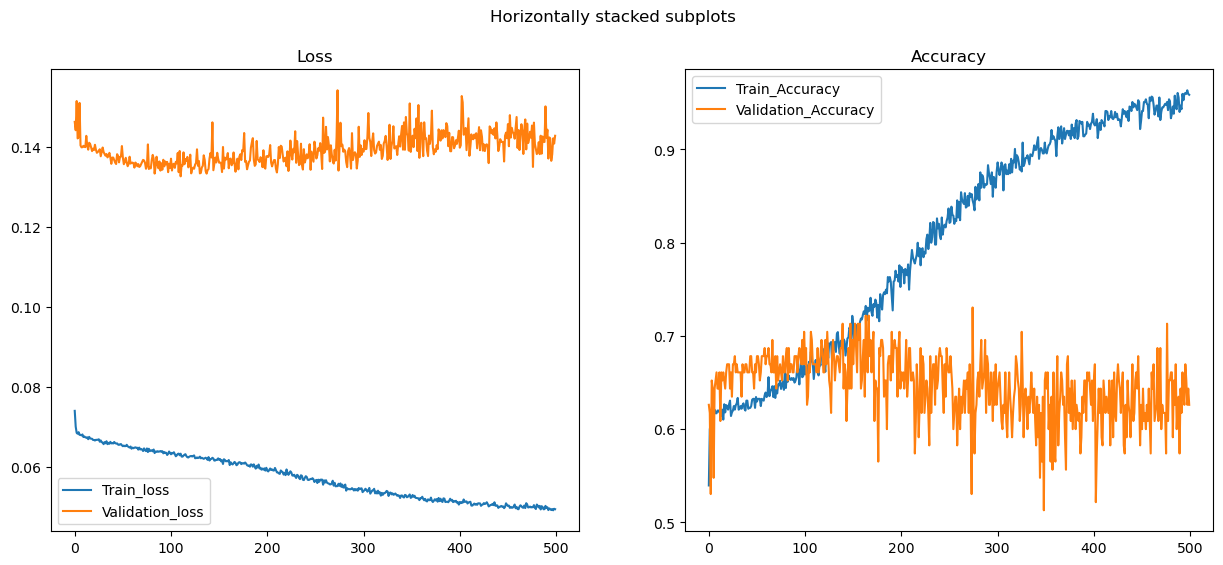

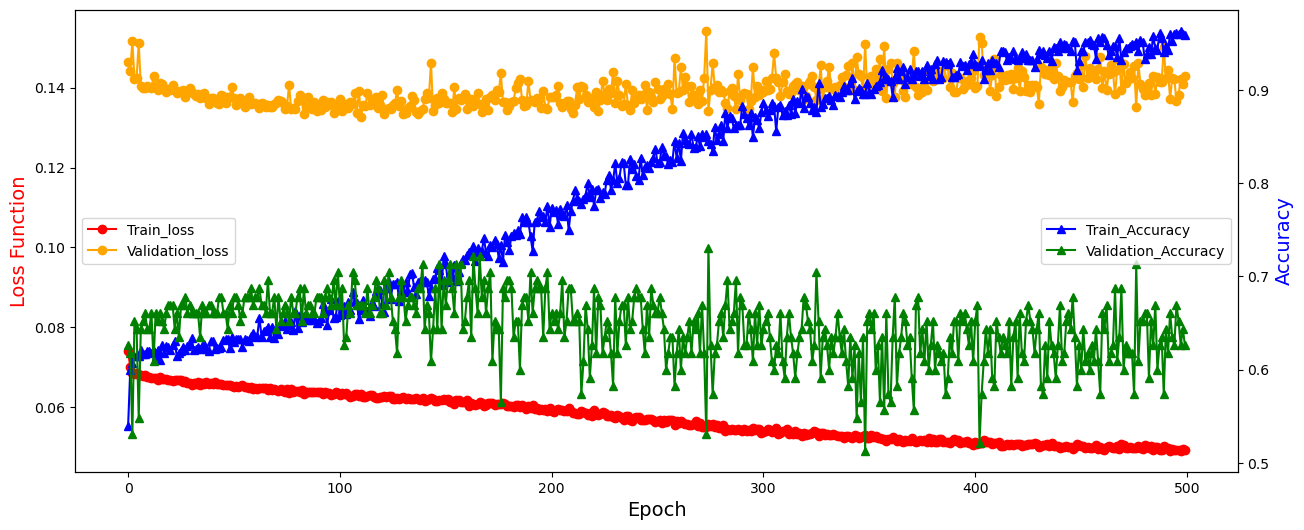

Current time: 171.947 minutes. Time expected till completion: 0.000 minutes
Finished training in: 171.947 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

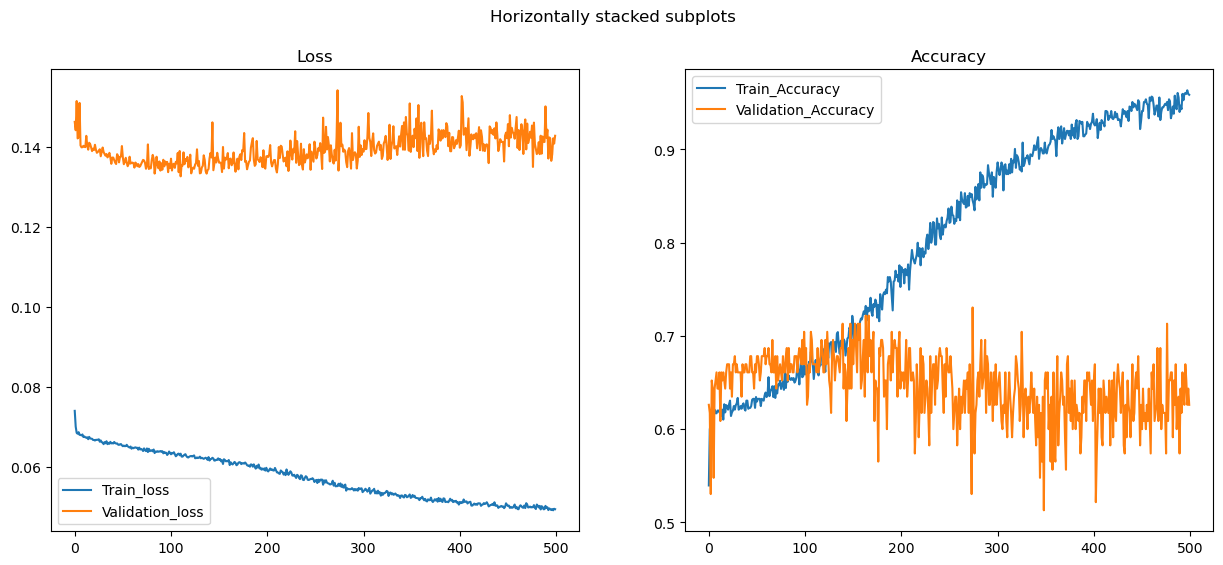

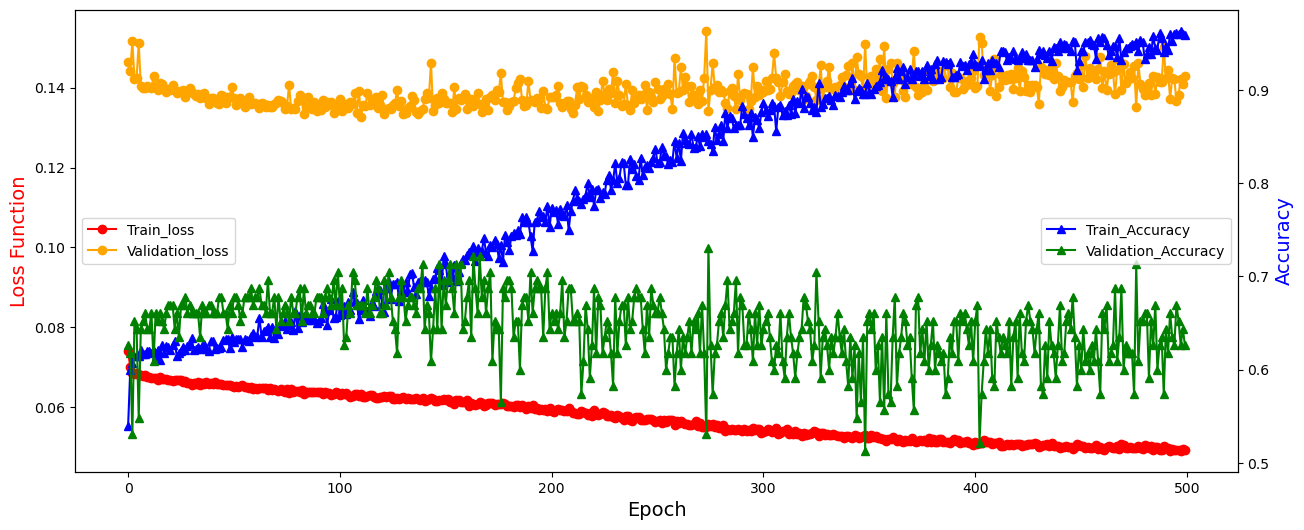

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 96.90522243713733%
Accuracy of the network on the 115 Validation instances: 62.608695652173914%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="09_10Conv_5Res_128FChannels_5Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points